In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import FormatStrFormatter

# import seaborn as sns

In [2]:
params = {
    'legend.fontsize': 'large',
    'figure.figsize': (16, 4), # 2.2*len(csvs)
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'xtick.major.size': 7.0,
    'ytick.major.size': 3.0,
    'pdf.fonttype': 42
}
pylab.rcParams.update(params)

In [3]:
def plot_csv(
    ax, csv_file, configs, Ds, D_labels,
    error_field='rel_frob_error',
    regression=False, y_lim=None,
    logscale=False, title='dataset',
    x_axis=True, ylabel='',
    ylog=False, plot_full_kernel=False
):
    
    bar_positions = []
    data_names = []
    
    #d_in = int(csv_file.split('_')[-2][1:])
    d_in = int(csv_file.split('/')[-1].split('_')[1][1:])
        
    df = pd.read_csv(csv_file)
    
    df['feature_train_ratio'] = df['feature_time'] / df['pred_time']

    Ds = [d_out * d_in for d_out in Ds]
    df = df[df['D'].isin(Ds)]
    seeds = df['seed'].unique()

    bar_positions = np.arange(len(Ds))
    width = 1./(len(configs)+1)
    
    cluster_mean = 0

    ref_error_mean = (df['test_error_ref'] / df['test_label_var']).mean()
    ref_mnll_mean = df['test_mnll_ref'].mean()
    
    # we need to pre-filter the dataframe so that we only accept complete seeds given D
    # for D in Ds:
    #     for seed in seeds:
    #         sel = df[(df['seed'] == seed) & (df['D'] == D)]
    #         if len(sel) < len(configs):
    #             # seed is incomplete
    #             df.drop(df.index[(df['seed'] == seed) & (df['D'] == D)], inplace = True)
    
    for j, (name, config) in enumerate(configs):
        
        df_sel = df[(df['proj'] == config['proj']) & (df['method'] == config['method'])]
        df_sel = df_sel[(df_sel['comp'] == config['complex'])]
        df_sel = df_sel[(df_sel['ahle'] == config['ahle'])]
        # df_sel = df_sel[(df_sel['seed'] < 10)]
        
        # dataset = df_sel['dataset'].iloc[0]

        if error_field == 'test_error' and regression:
            df_sel[error_field] = df_sel[error_field] / df['test_label_var']
        
        df_sel = df_sel.groupby(['D'])

        error_means = df_sel[error_field].mean()
        error_stds = df_sel[error_field].std()
        error_max = df_sel[error_field].max()
        error_min = df_sel[error_field].min()
        error_median = df_sel[error_field].median()
        
        ax.bar(
            bar_positions + j*width, error_means,
            yerr=error_stds,
            error_kw=dict(lw=1, capsize=1, capthick=1, alpha=0.3),
            color=config['color'],
            width=width,
            label=name,
            align='edge'
        )

    if plot_full_kernel:
        if error_field == 'test_error':
            ax.hlines(y=ref_error_mean, xmin=0, xmax=bar_positions[-1]+1, linewidth=2, color='black', linestyle='dashed')
        elif error_field == 'test_mnll':
            ax.hlines(y=ref_mnll_mean, xmin=0, xmax=bar_positions[-1]+1, linewidth=2, color='black', linestyle='dashed')
    
    ax.set_xticks(
        bar_positions+len(configs)*width/2.,
        labels=D_labels
    )
    if not x_axis:
#         ax.set_xticks([])
        ax.set_xticklabels([])

#     if error_field == 'test_kl':
#         ax.yaxis.set_major_formatter(FormatStrFormatter("%.0e"))

    if logscale:
        ax.set_yscale('log')

    if ylabel != '':
        ax.set_ylabel(ylabel)
        
    if y_lim is not None:
        ax.set_ylim(y_lim)
        
    if ylog:
        ax.set_yscale('log')
        
#     ax.set_xlabel('Feature Map Dimension ' + r'$D$')
    ax.set_title(title)

#     ax.legend() # loc='upper center', ncol=8

In [7]:
colors = plt.get_cmap('tab20')(np.linspace(0, 1.0, 20))
colors = np.flip(colors, axis=0)

In [5]:
colors = plt.get_cmap('tab20c')(np.linspace(0, 0.8, 17))[::2]
colors = np.flip(colors, axis=0)

In [8]:
configs = [
    ('Gaussian', {'method': 'poly_sketch', 'proj': 'gaussian', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[0]}),
    ('Complex Gaussian', {'method': 'poly_sketch', 'proj': 'gaussian', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[1]}),
    ('Rademacher', {'method': 'poly_sketch', 'proj': 'rademacher', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[2]}),
    ('Complex Rademacher', {'method': 'poly_sketch', 'proj': 'rademacher', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[3]}),
    ('TensorSRHT', {'method': 'poly_sketch', 'proj': 'srht', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[4]}),
    ('Complex TensorSRHT', {'method': 'poly_sketch', 'proj': 'srht', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[5]}),
    ('Ahle et al. TensorSRHT', {'method': 'poly_sketch', 'proj': 'srht', 'complex': False, 'ahle': True, 'comp_real': False, 'color': colors[6]}),
    ('Complex Ahle et al. TensorSRHT', {'method': 'poly_sketch', 'proj': 'srht', 'complex': True, 'ahle': True, 'comp_real': False, 'color': colors[7]}),
    ('TensorSketch', {'method': 'poly_sketch', 'proj': 'countsketch_scatter', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[8]}),
    ('SRF', {'method': 'srf', 'proj': 'gaussian', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[9]}),
    ('Orth. SRF', {'method': 'srf', 'proj': 'srht', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[10]}),
    ('Complex Orth. SRF', {'method': 'srf', 'proj': 'srht', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[11]}),
    ('Rnd. Maclaurin Rademacher', {'method': 'maclaurin_p', 'proj': 'rademacher', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[12]}),
    ('Opt. Maclaurin Rademacher', {'method': 'maclaurin', 'proj': 'rademacher', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[13]}),
    ('Opt. Maclaurin TensorSRHT', {'method': 'maclaurin', 'proj': 'srht', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[14]}),
    ('Opt. Complex Maclaurin TensorSRHT', {'method': 'maclaurin', 'proj': 'srht', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[15]}),
]

## p=3,7,10, a=2 zero-centered

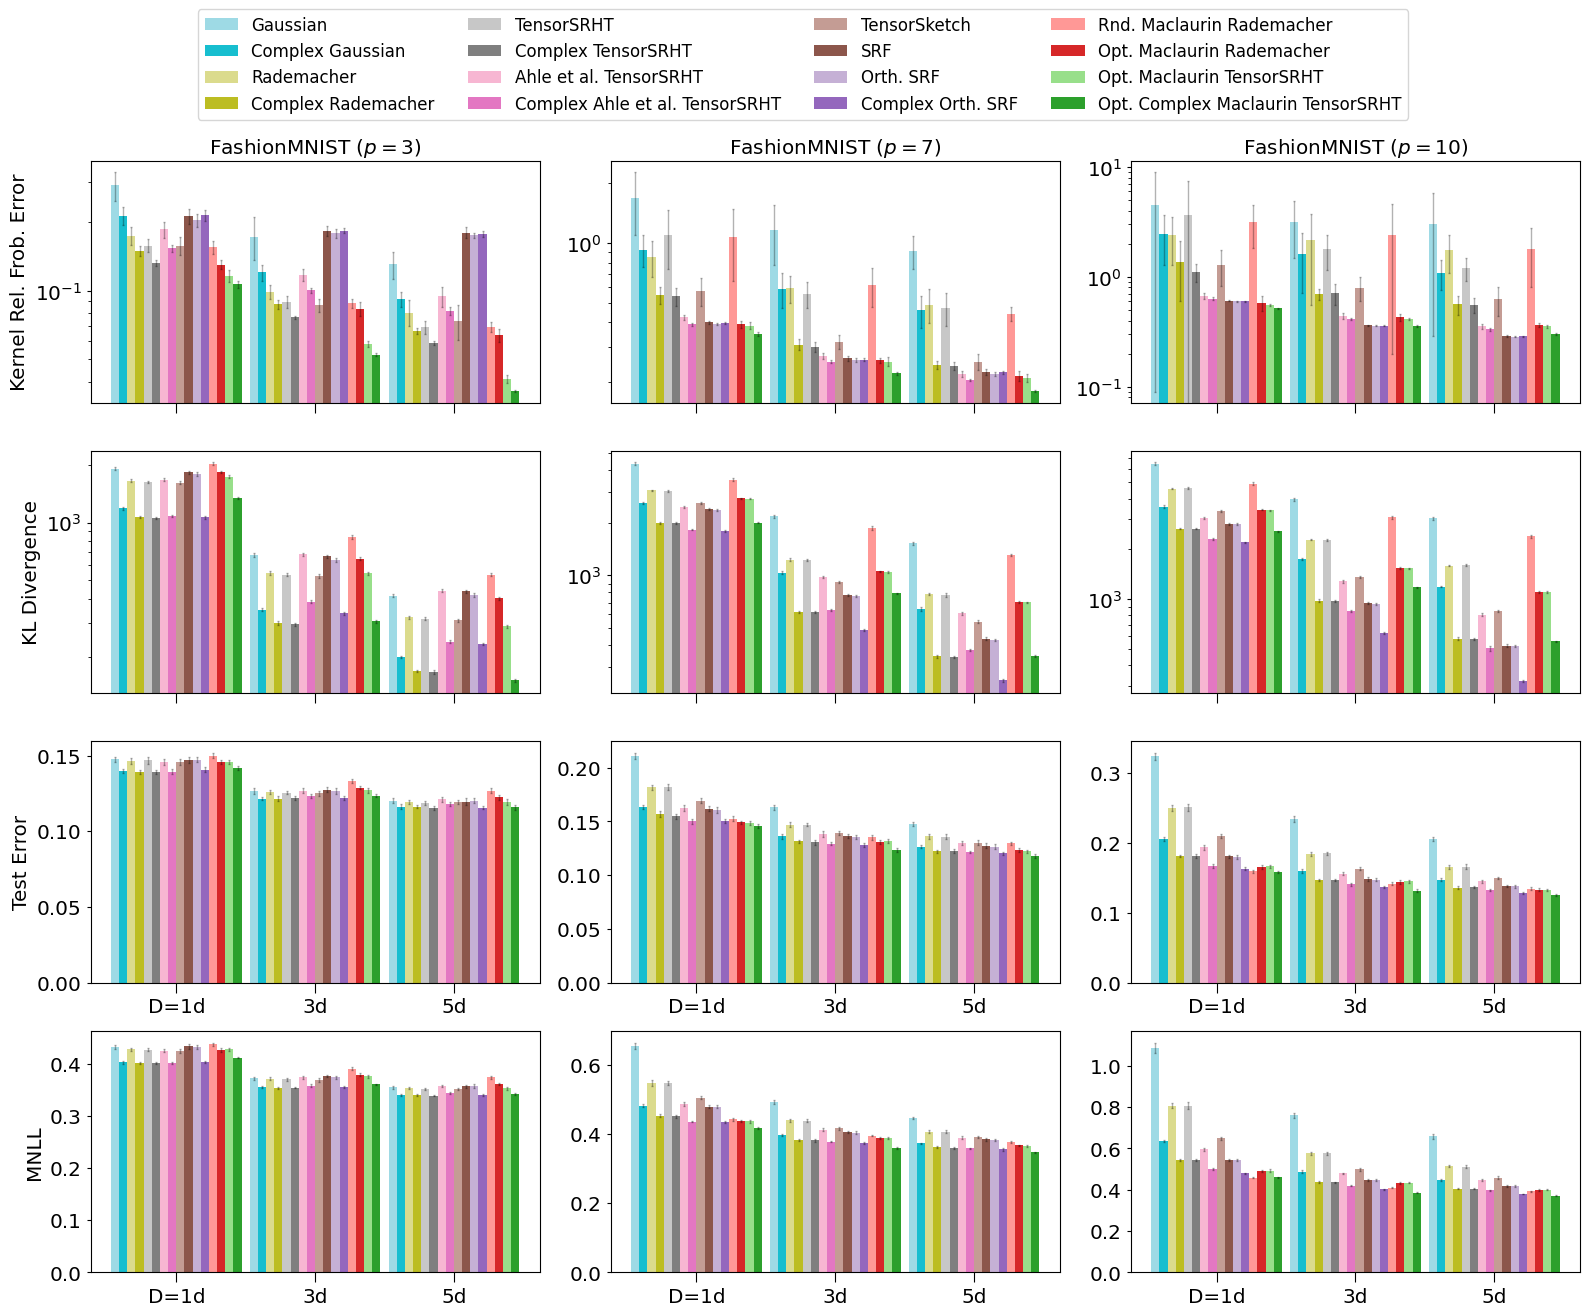

In [35]:
csv_files = [
    '../csv/poly3_approx_a2/FashionMNIST_d1024_n70000_centering_True.csv',
    '../csv/poly7_approx_a2/FashionMNIST_d1024_n70000_centering_True.csv',
    '../csv/poly10_approx_a2/FashionMNIST_d1024_n70000_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=False, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=False, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=False) # plot_full_kernel=True

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=False) # plot_full_kernel=True

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.25,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/mnist_cifar10_big.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

p=3

- Maclaurin and **Compelx RF** fully dominate Frob Error and KL Divergence
- Maclaurin methods a bit weaker in test error and MNLL
- => Recommendation: Complex RF

p=7, 10
- Maclaurin dominates Frob Error
- Maclaurin weak in KL Div.
- Maclaurin dominates Test Error

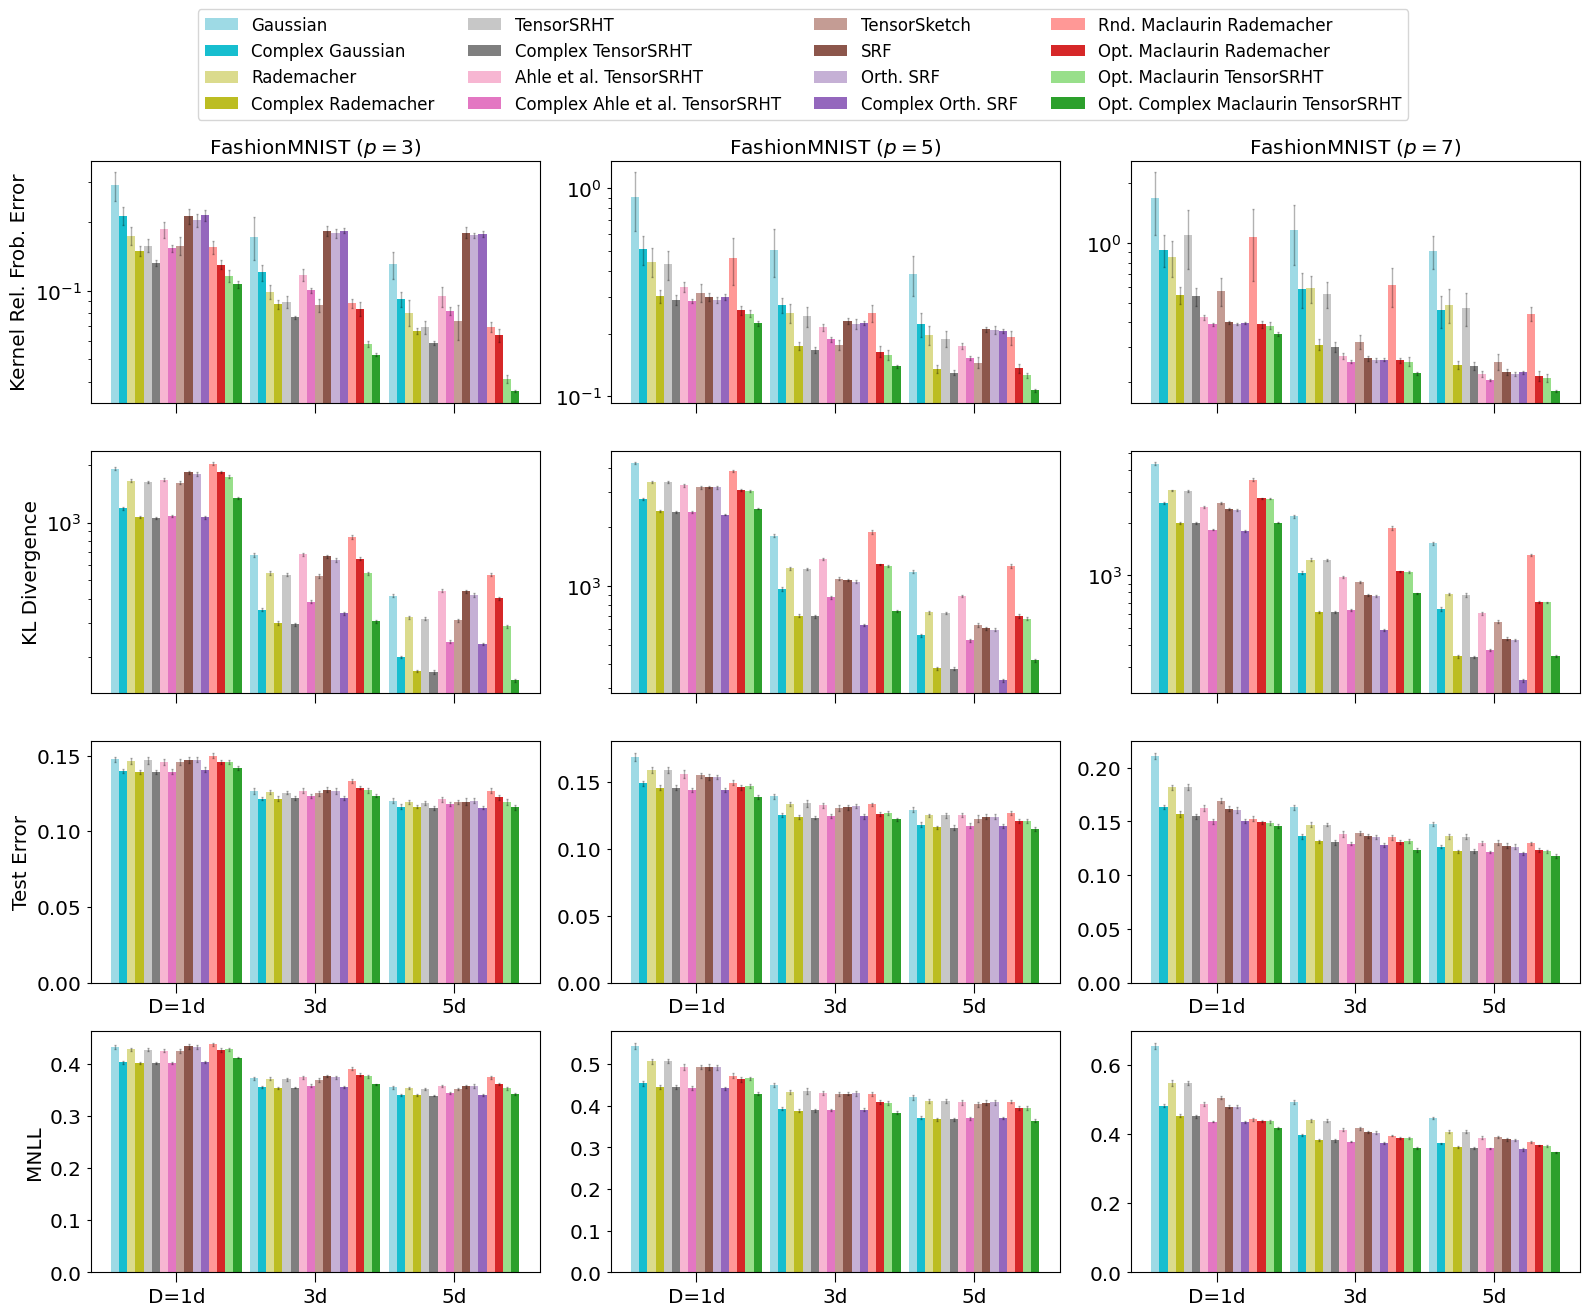

In [122]:
csv_files = [
    '../csv/poly3_approx_a2/FashionMNIST_d1024_n70000_centering_True.csv',
    '../csv/poly5_approx_a2/FashionMNIST_d1024_n70000_centering_True.csv',
    '../csv/poly7_approx_a2/FashionMNIST_d1024_n70000_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=False, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=False, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=False) # plot_full_kernel=True

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=False) # plot_full_kernel=True

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.25,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/mnist_cifar10_big.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

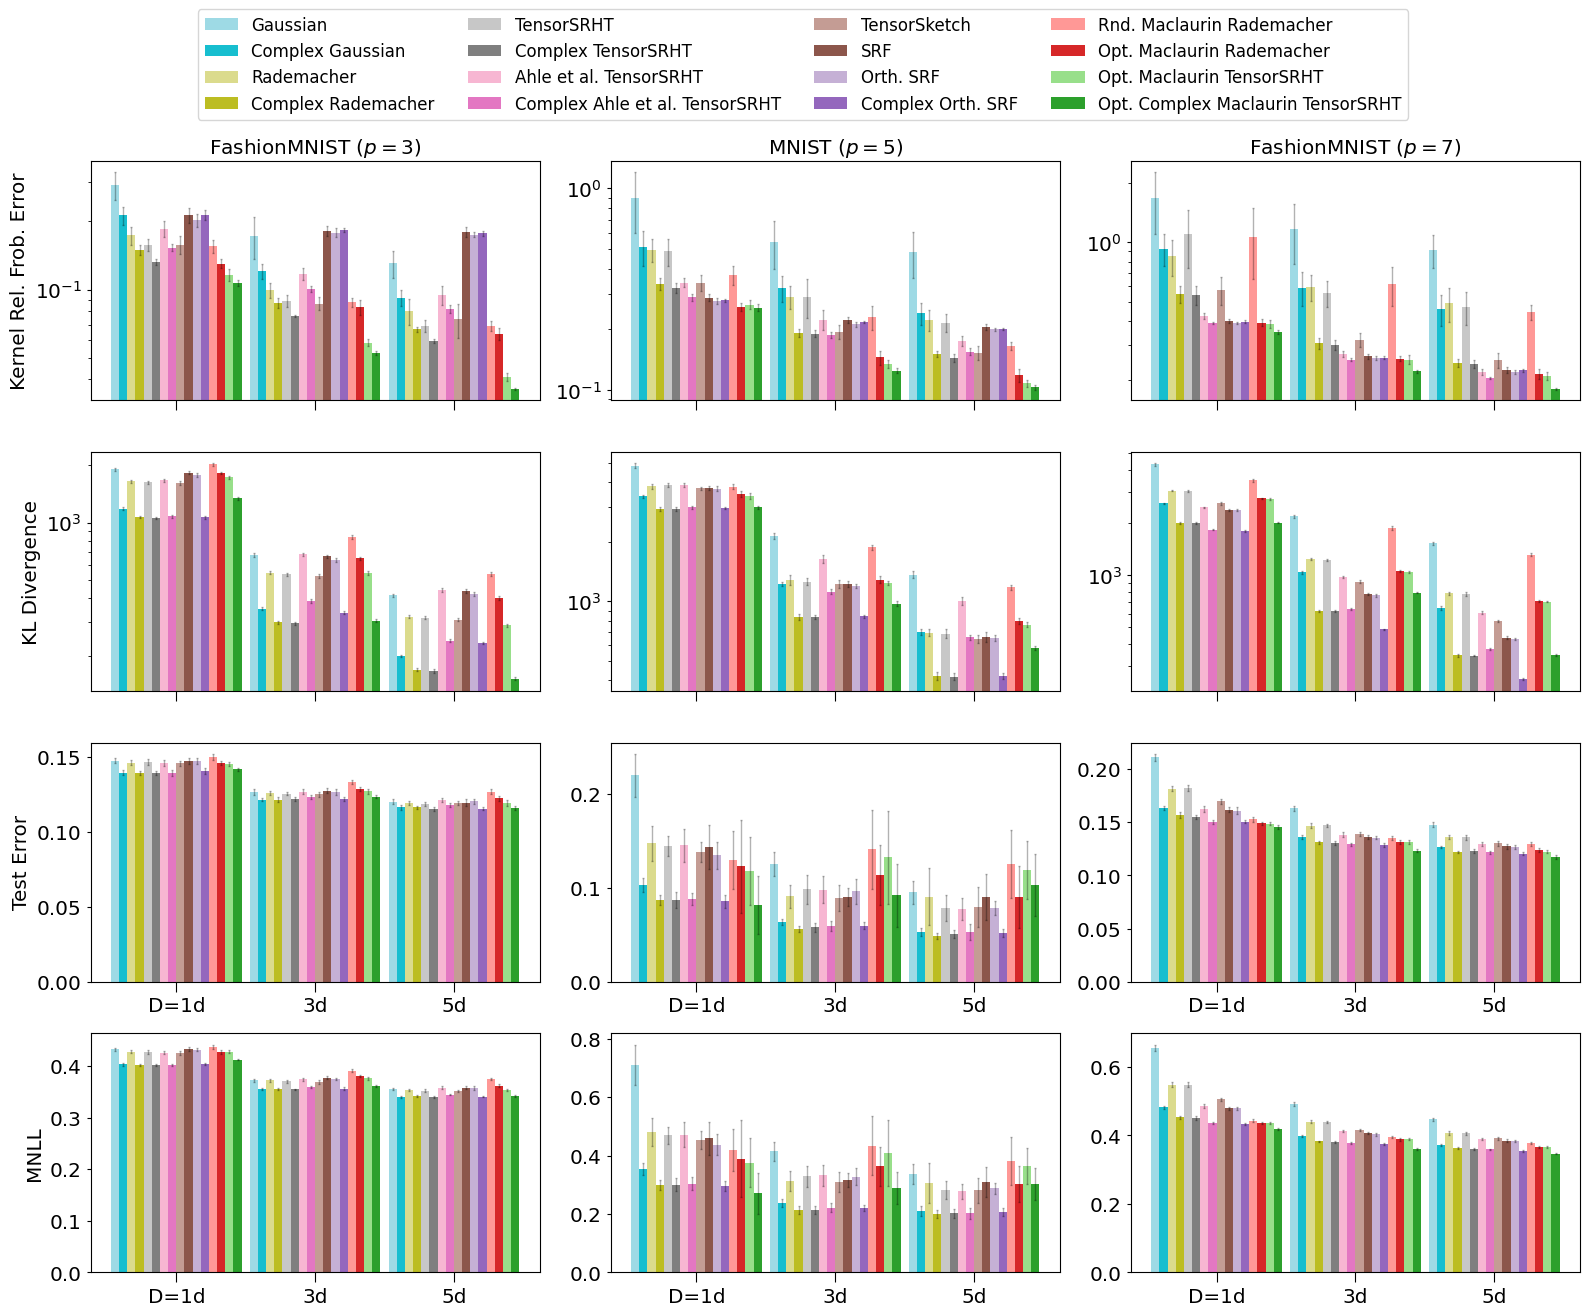

In [123]:
csv_files = [
    '../csv/poly3_approx_a2/FashionMNIST_d1024_n70000_centering_True.csv',
    '../csv/poly5_approx_a2/MNIST_d1024_n70000_centering_True.csv',
    '../csv/poly7_approx_a2/FashionMNIST_d1024_n70000_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=False, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=False, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=False) # plot_full_kernel=True

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=False) # plot_full_kernel=True

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.25,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/mnist_cifar10_big.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

## p=3,7,10, a=4 zero-centered

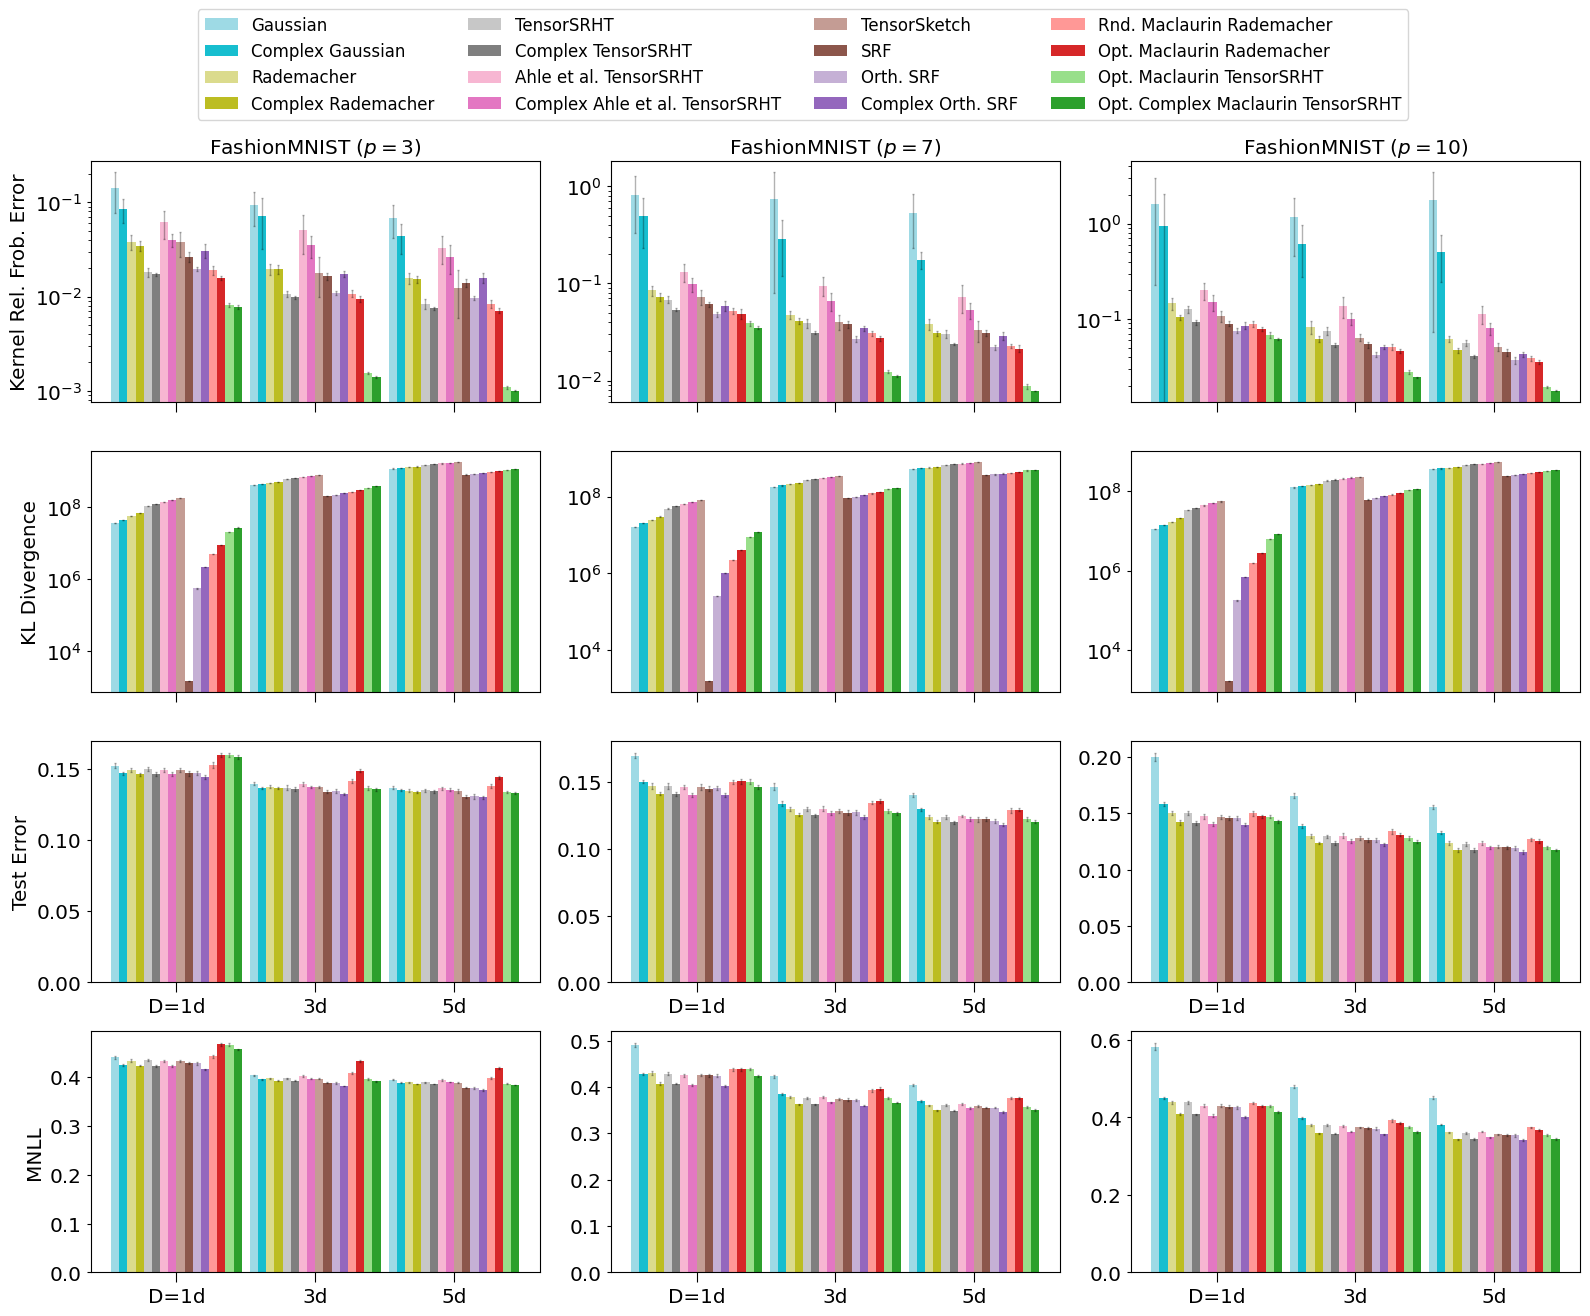

In [7]:
csv_files = [
    '../csv/poly3_approx_a4/FashionMNIST_d1024_n70000_centering_True.csv',
    '../csv/poly7_approx_a4/FashionMNIST_d1024_n70000_centering_True.csv',
    '../csv/poly10_approx_a4/FashionMNIST_d1024_n70000_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=False, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=False, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=False) # plot_full_kernel=True

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=False) # plot_full_kernel=True

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.25,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/mnist_cifar10_big.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

## p=3,7,10, a=2 not centered

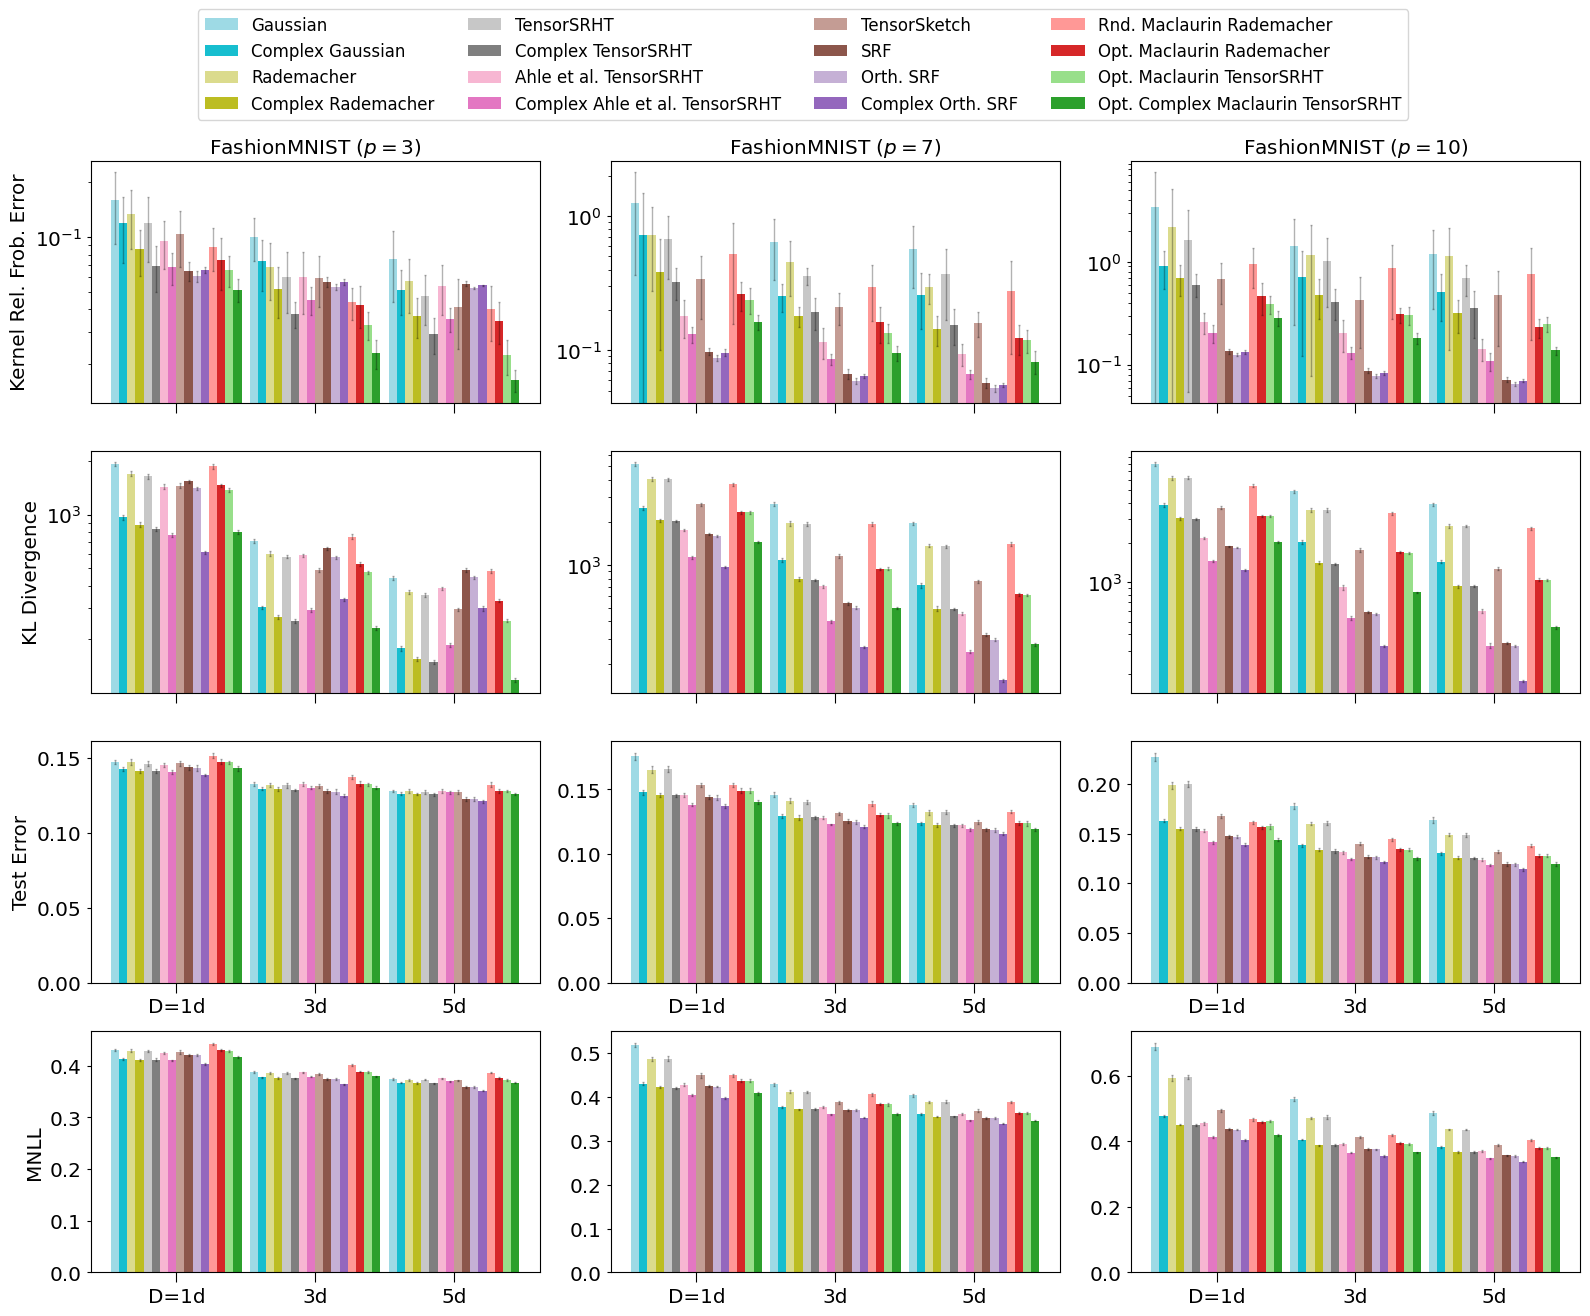

In [36]:
csv_files = [
    '../csv/poly3_approx_a2/FashionMNIST_d1024_n70000_centering_False.csv',
    '../csv/poly7_approx_a2/FashionMNIST_d1024_n70000_centering_False.csv',
    '../csv/poly10_approx_a2/FashionMNIST_d1024_n70000_centering_False.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=False, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=False, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=False) # plot_full_kernel=True

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=False) # plot_full_kernel=True

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.25,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/mnist_cifar10_big.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

- SRF dominates everything except p=3 Frob and KL where Maclaurin dominates

## Classification

## p=3

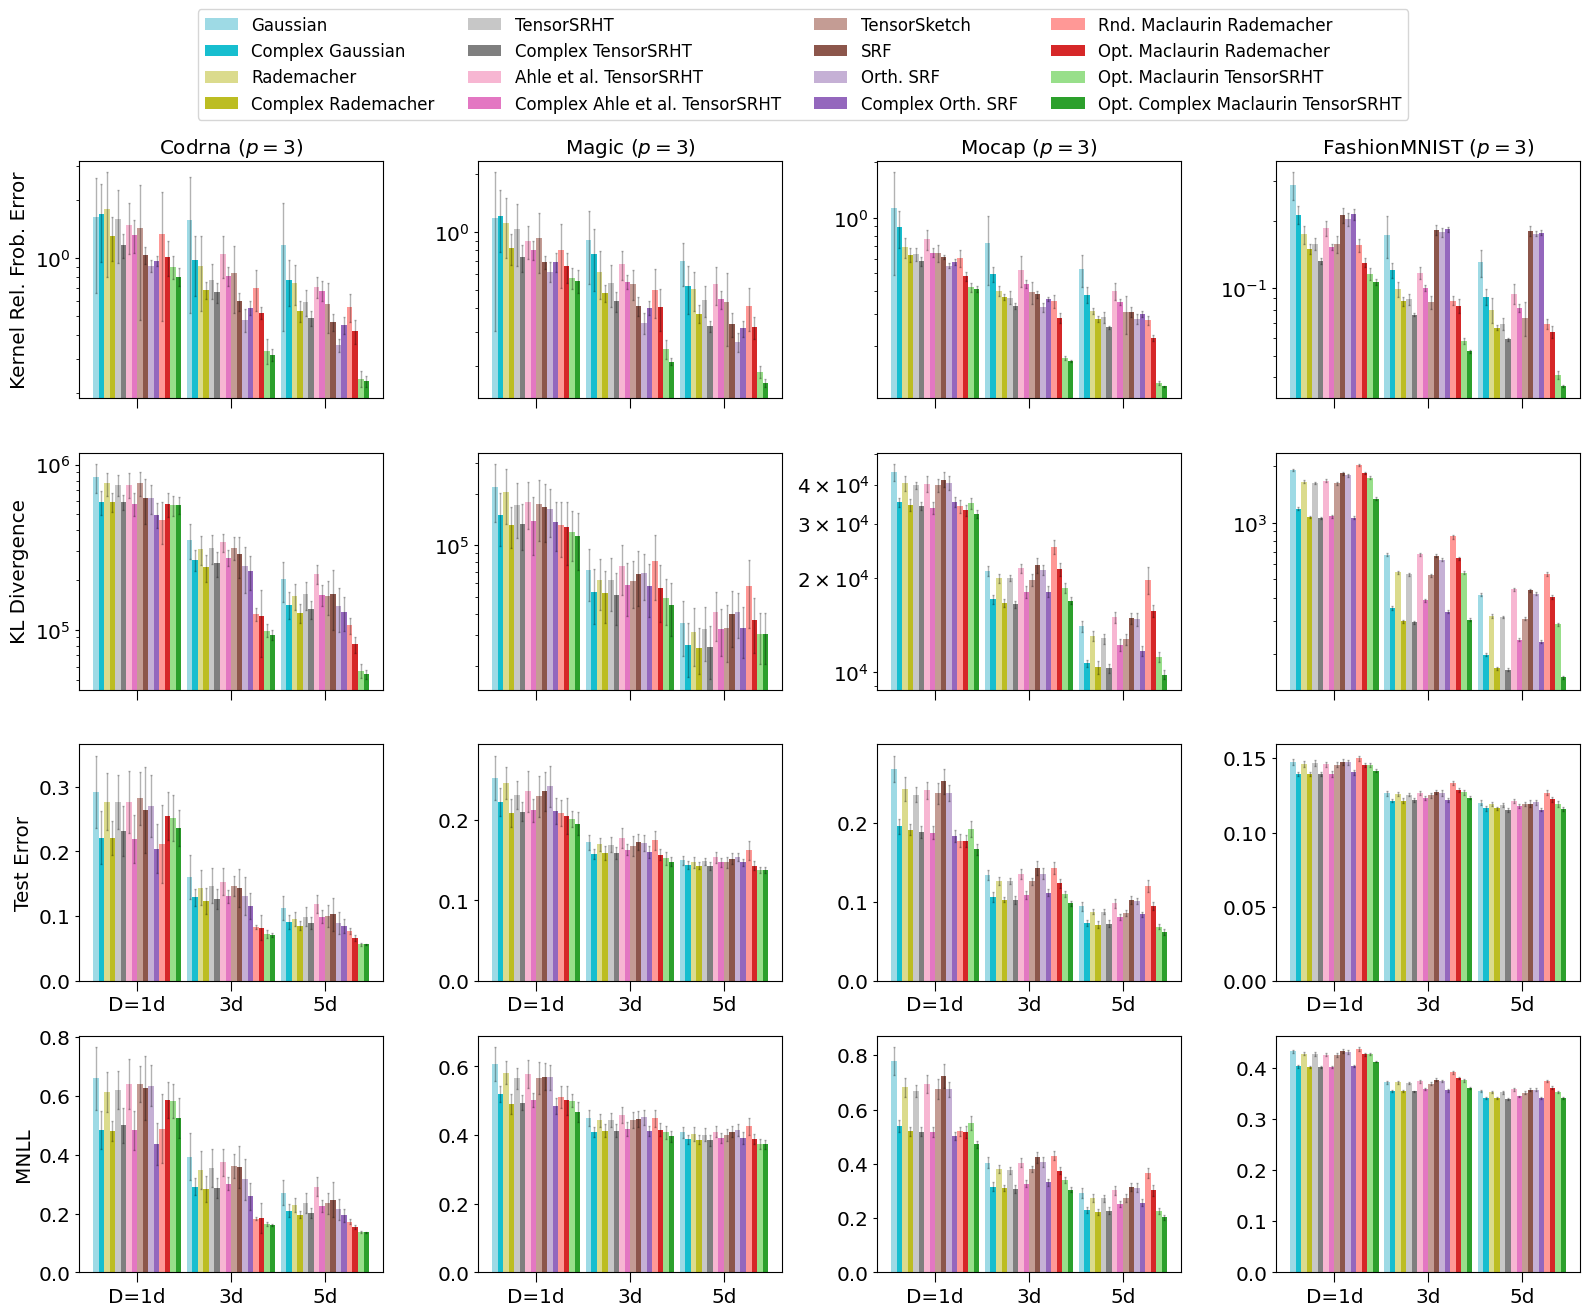

In [10]:
csv_files = [
    '../csv/poly3_approx_a2/Codrna_d8_n331152_centering_True.csv',
    '../csv/poly3_approx_a2/Magic_d16_n19020_centering_True.csv',
    '../csv/poly3_approx_a2/Mocap_d64_n78095_centering_True.csv',
    '../csv/poly3_approx_a2/FashionMNIST_d1024_n70000_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=False, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=False, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=False, plot_full_kernel=False) # 

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=False, plot_full_kernel=False) # 

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.25,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/mnist_cifar10_big.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

## p=7

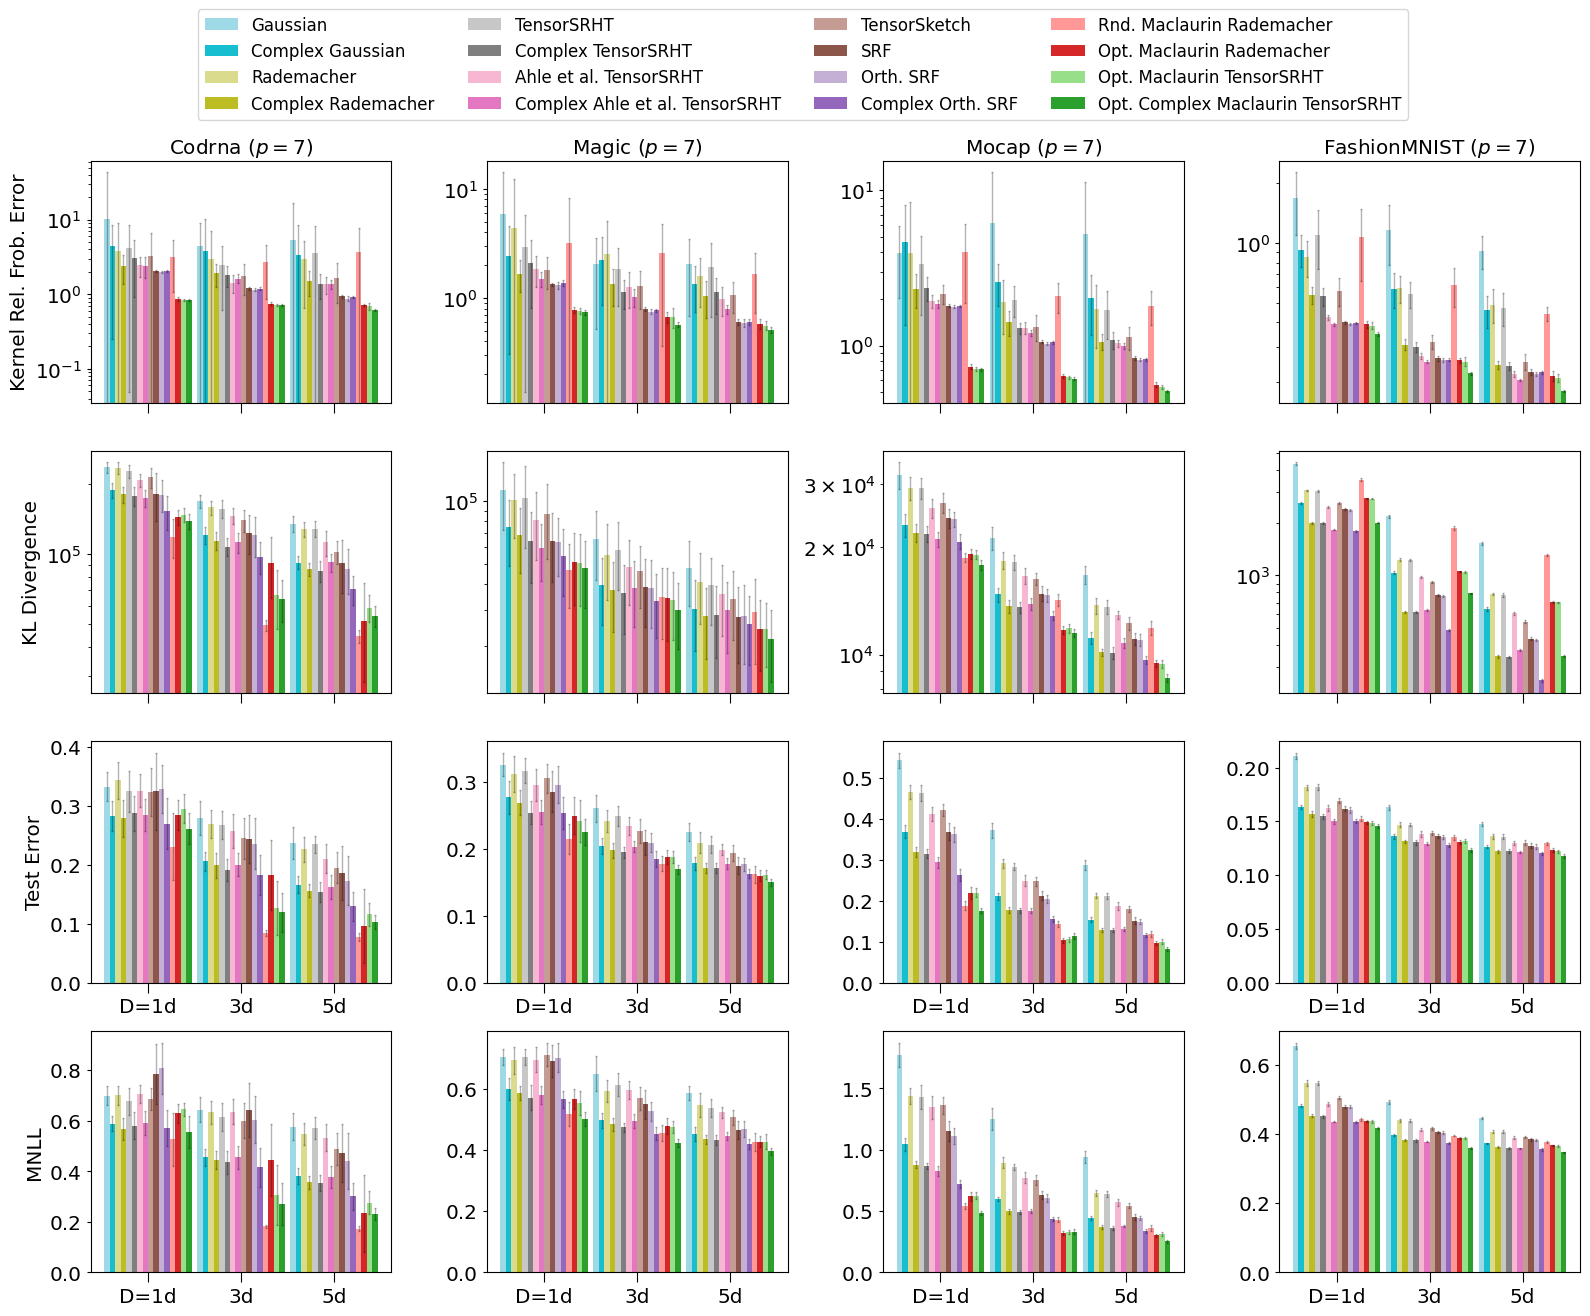

In [12]:
csv_files = [
    '../csv/poly7_approx_a2/Codrna_d8_n331152_centering_True.csv',
    '../csv/poly7_approx_a2/Magic_d16_n19020_centering_True.csv',
    '../csv/poly7_approx_a2/Mocap_d64_n78095_centering_True.csv',
    '../csv/poly7_approx_a2/FashionMNIST_d1024_n70000_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=False, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=False, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=False, plot_full_kernel=False) # 

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=False, plot_full_kernel=False) # 

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.25,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/mnist_cifar10_big.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

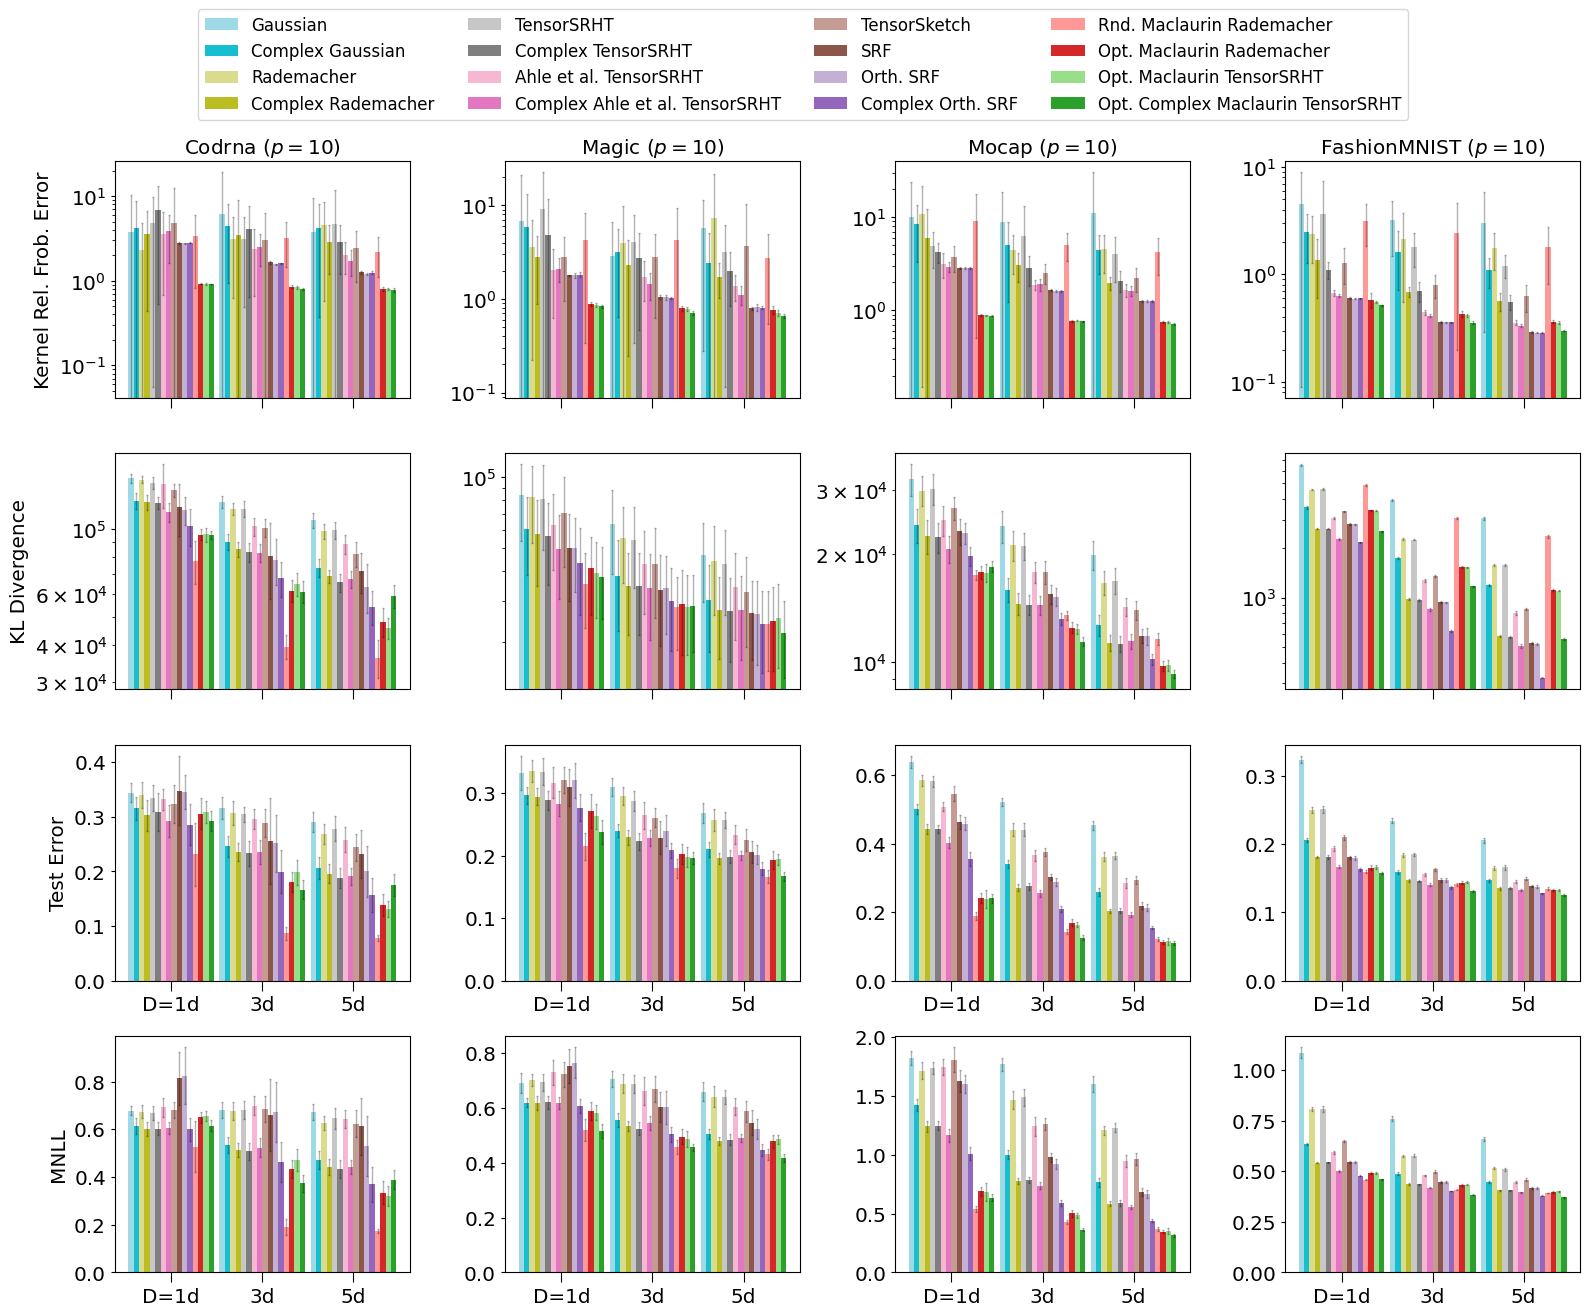

In [14]:
csv_files = [
    '../csv/poly10_approx_a2/Codrna_d8_n331152_centering_True.csv',
    '../csv/poly10_approx_a2/Magic_d16_n19020_centering_True.csv',
    '../csv/poly10_approx_a2/Mocap_d64_n78095_centering_True.csv',
    '../csv/poly10_approx_a2/FashionMNIST_d1024_n70000_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=False, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=False, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=False, plot_full_kernel=False) # 

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=False, plot_full_kernel=False) # 

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.25,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/mnist_cifar10_big.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

## Regression

## p=3

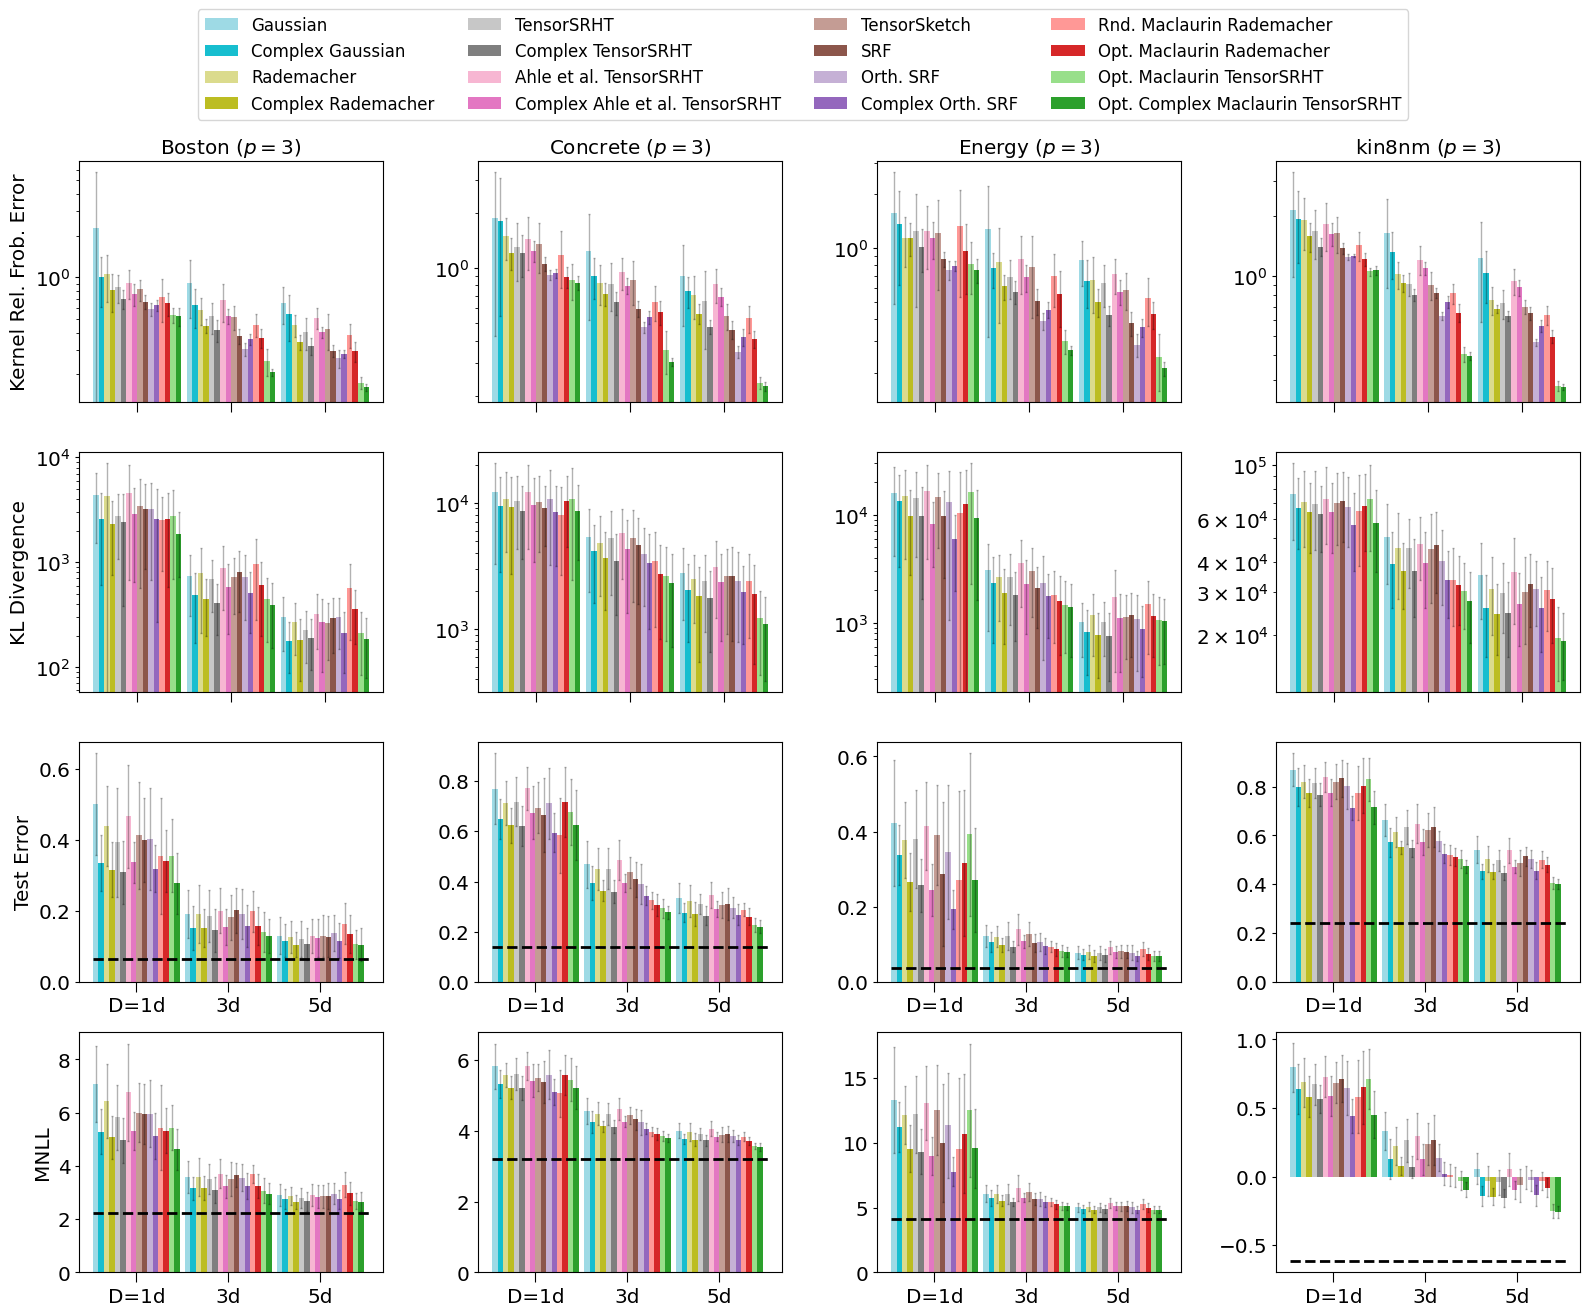

In [101]:
csv_files = [
    '../csv/poly3_approx_a2/Boston_d16_n506_centering_True.csv',
    '../csv/poly3_approx_a2/Concrete_d8_n1030_centering_True.csv',
    '../csv/poly3_approx_a2/Energy_d8_n768_centering_True.csv',
    '../csv/poly3_approx_a2/kin8nm_d8_n8192_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=False, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=False, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.25,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/mnist_cifar10_big.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

In [ ]:
        "config/datasets/naval.json",
        "config/datasets/powerplant.json",
        "config/datasets/protein.json",
        "config/datasets/yacht.json"

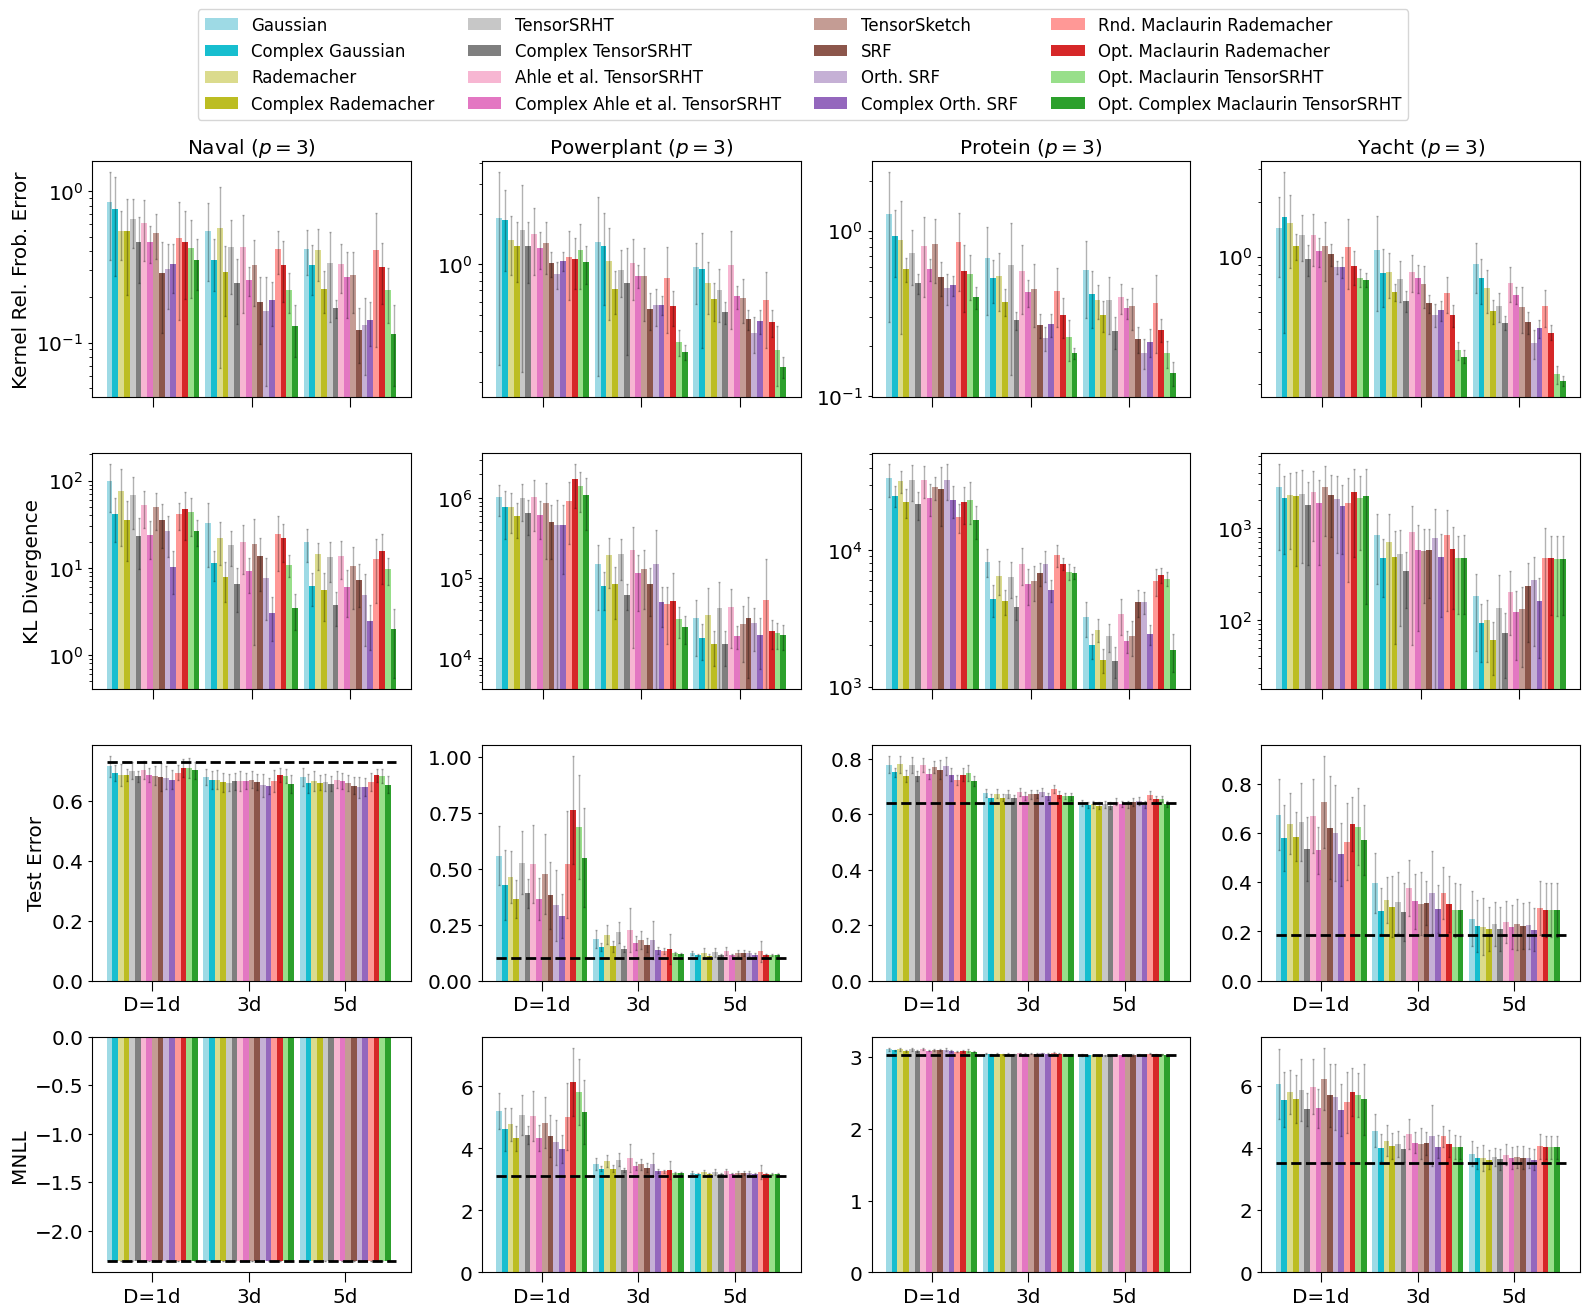

In [102]:
csv_files = [
    '../csv/poly3_approx_a2/Naval_d16_n11934_centering_True.csv',
    '../csv/poly3_approx_a2/Powerplant_d4_n9568_centering_True.csv',
    '../csv/poly3_approx_a2/Protein_d16_n45730_centering_True.csv',
    '../csv/poly3_approx_a2/Yacht_d8_n308_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=False, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=False, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.25,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/mnist_cifar10_big.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

## p=5

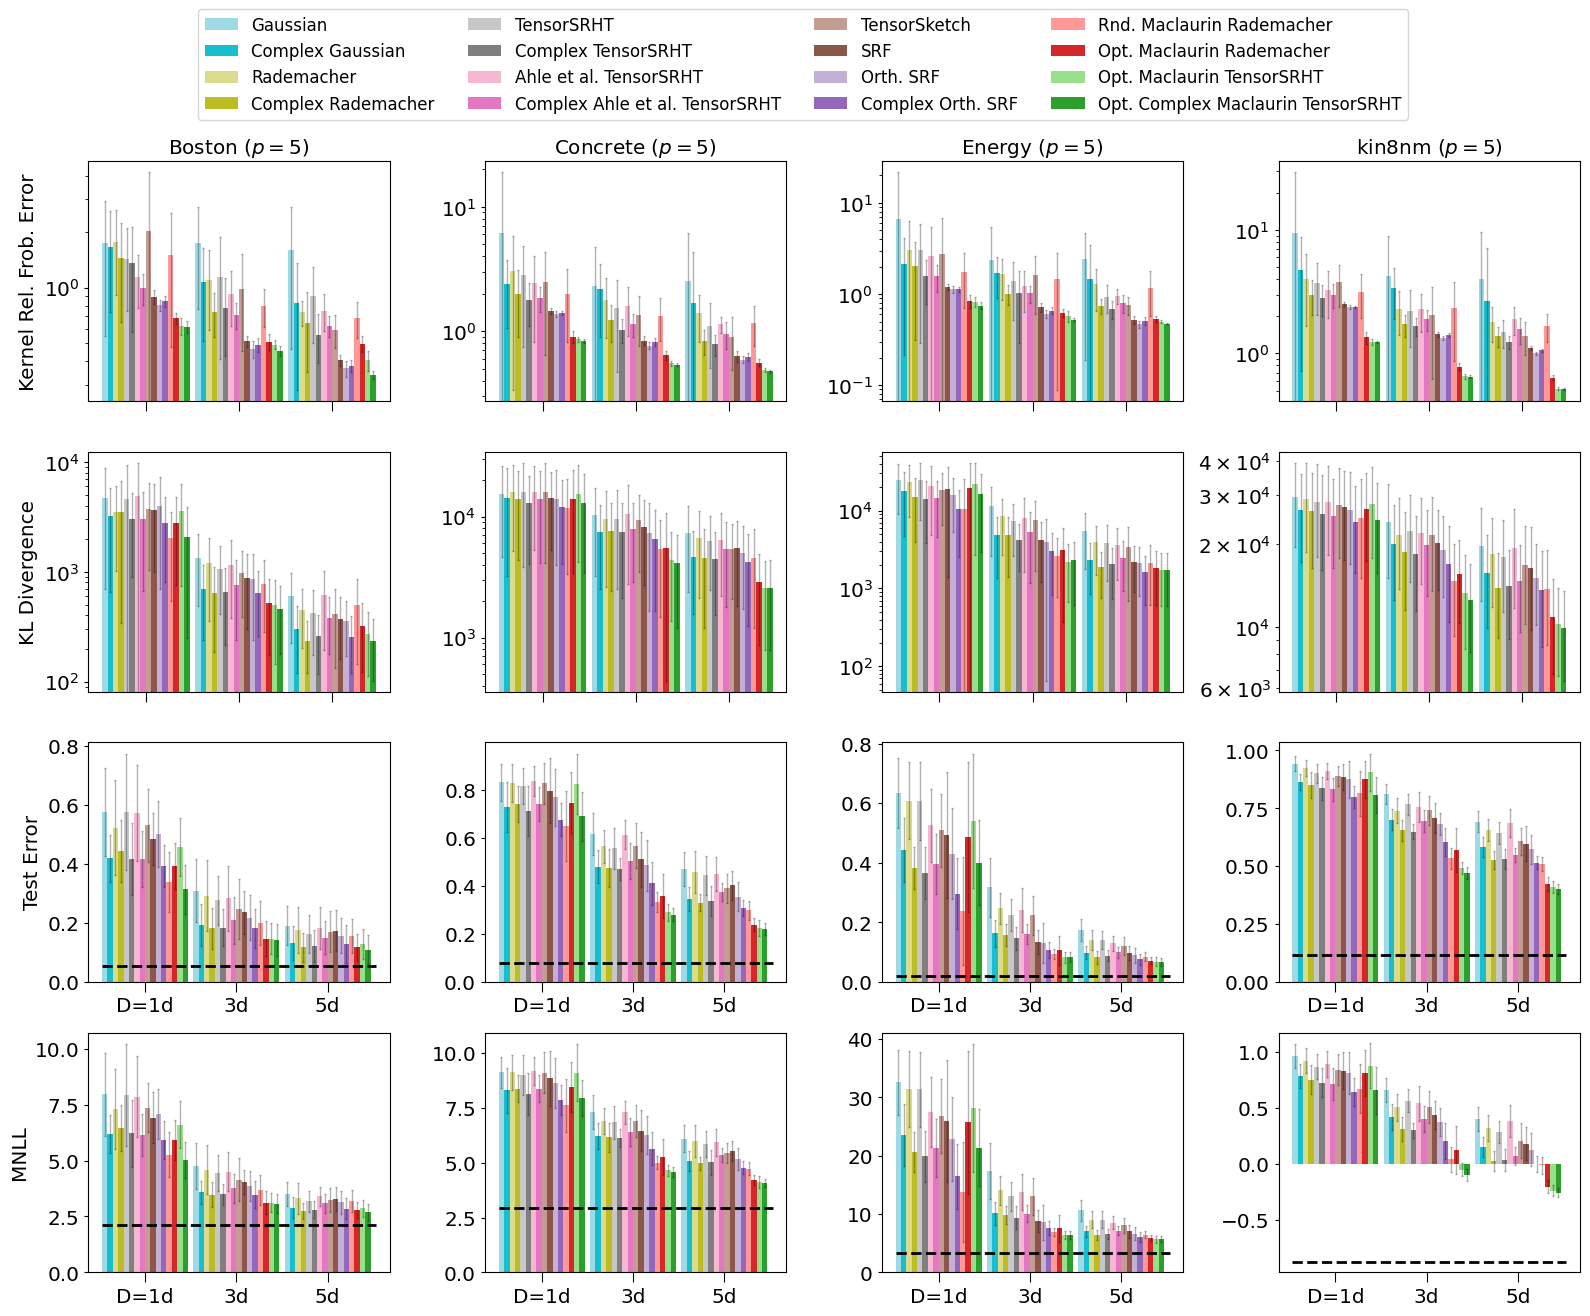

In [10]:
csv_files = [
    '../csv/poly5_approx_a2/Boston_d16_n506_centering_True.csv',
    '../csv/poly5_approx_a2/Concrete_d8_n1030_centering_True.csv',
    '../csv/poly5_approx_a2/Energy_d8_n768_centering_True.csv',
    '../csv/poly5_approx_a2/kin8nm_d8_n8192_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=False, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=False, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.25,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/mnist_cifar10_big.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

## p=7

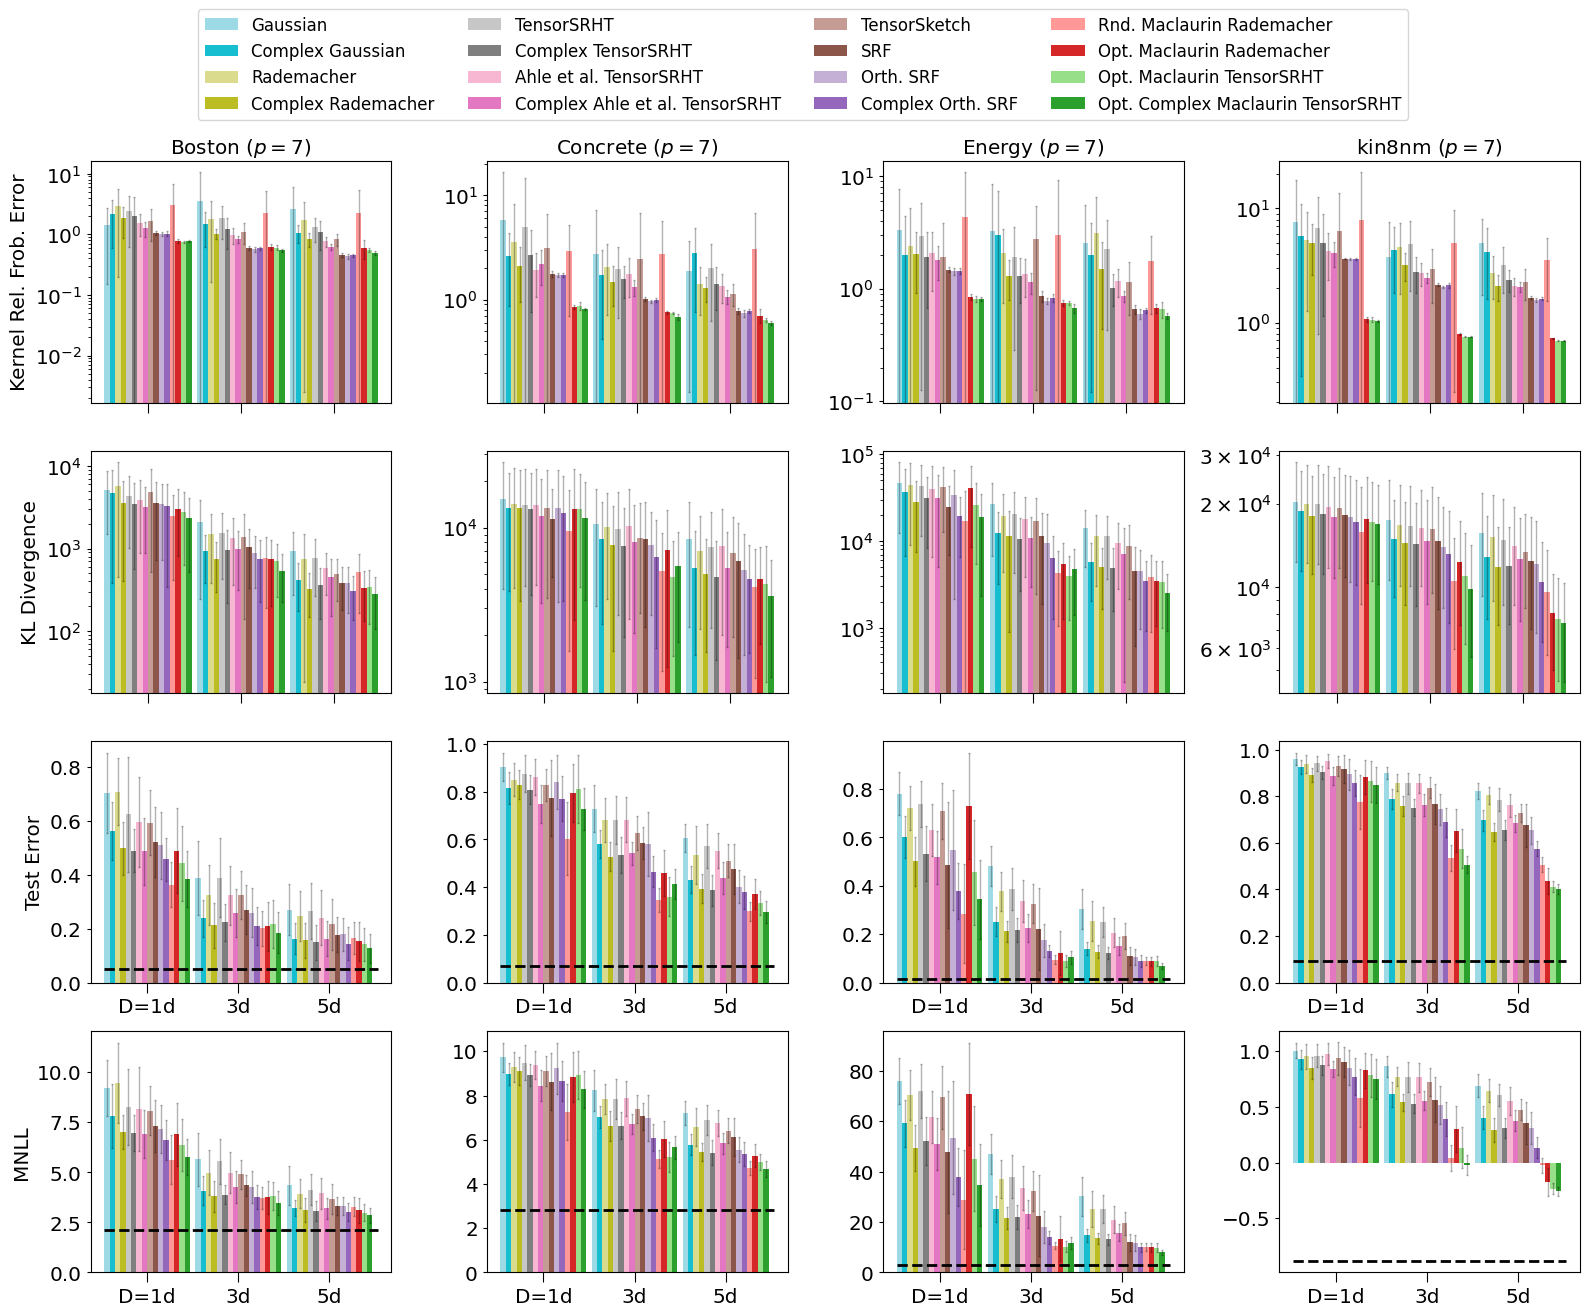

In [103]:
csv_files = [
    '../csv/poly7_approx_a2/Boston_d16_n506_centering_True.csv',
    '../csv/poly7_approx_a2/Concrete_d8_n1030_centering_True.csv',
    '../csv/poly7_approx_a2/Energy_d8_n768_centering_True.csv',
    '../csv/poly7_approx_a2/kin8nm_d8_n8192_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=False, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=False, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.25,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/mnist_cifar10_big.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

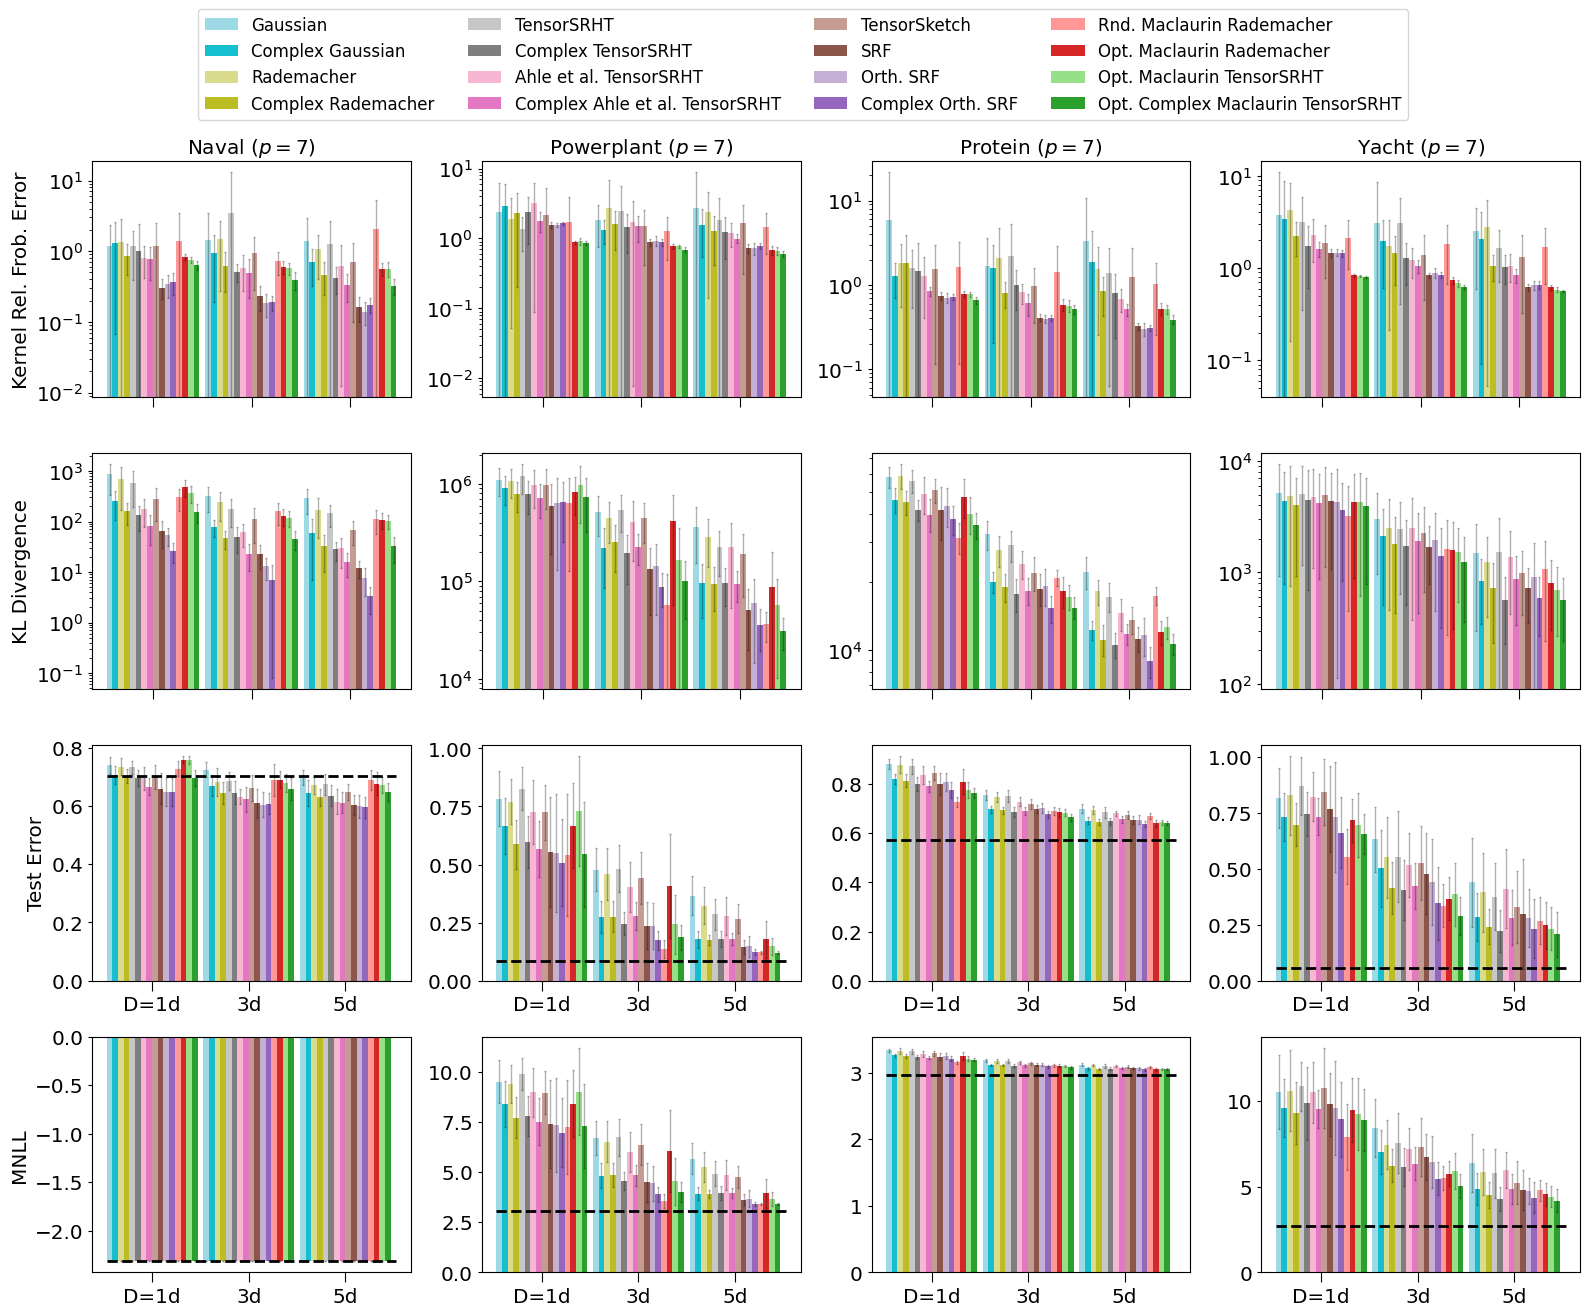

In [104]:
csv_files = [
    '../csv/poly7_approx_a2/Naval_d16_n11934_centering_True.csv',
    '../csv/poly7_approx_a2/Powerplant_d4_n9568_centering_True.csv',
    '../csv/poly7_approx_a2/Protein_d16_n45730_centering_True.csv',
    '../csv/poly7_approx_a2/Yacht_d8_n308_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=False, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=False, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.25,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/mnist_cifar10_big.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

## p=10

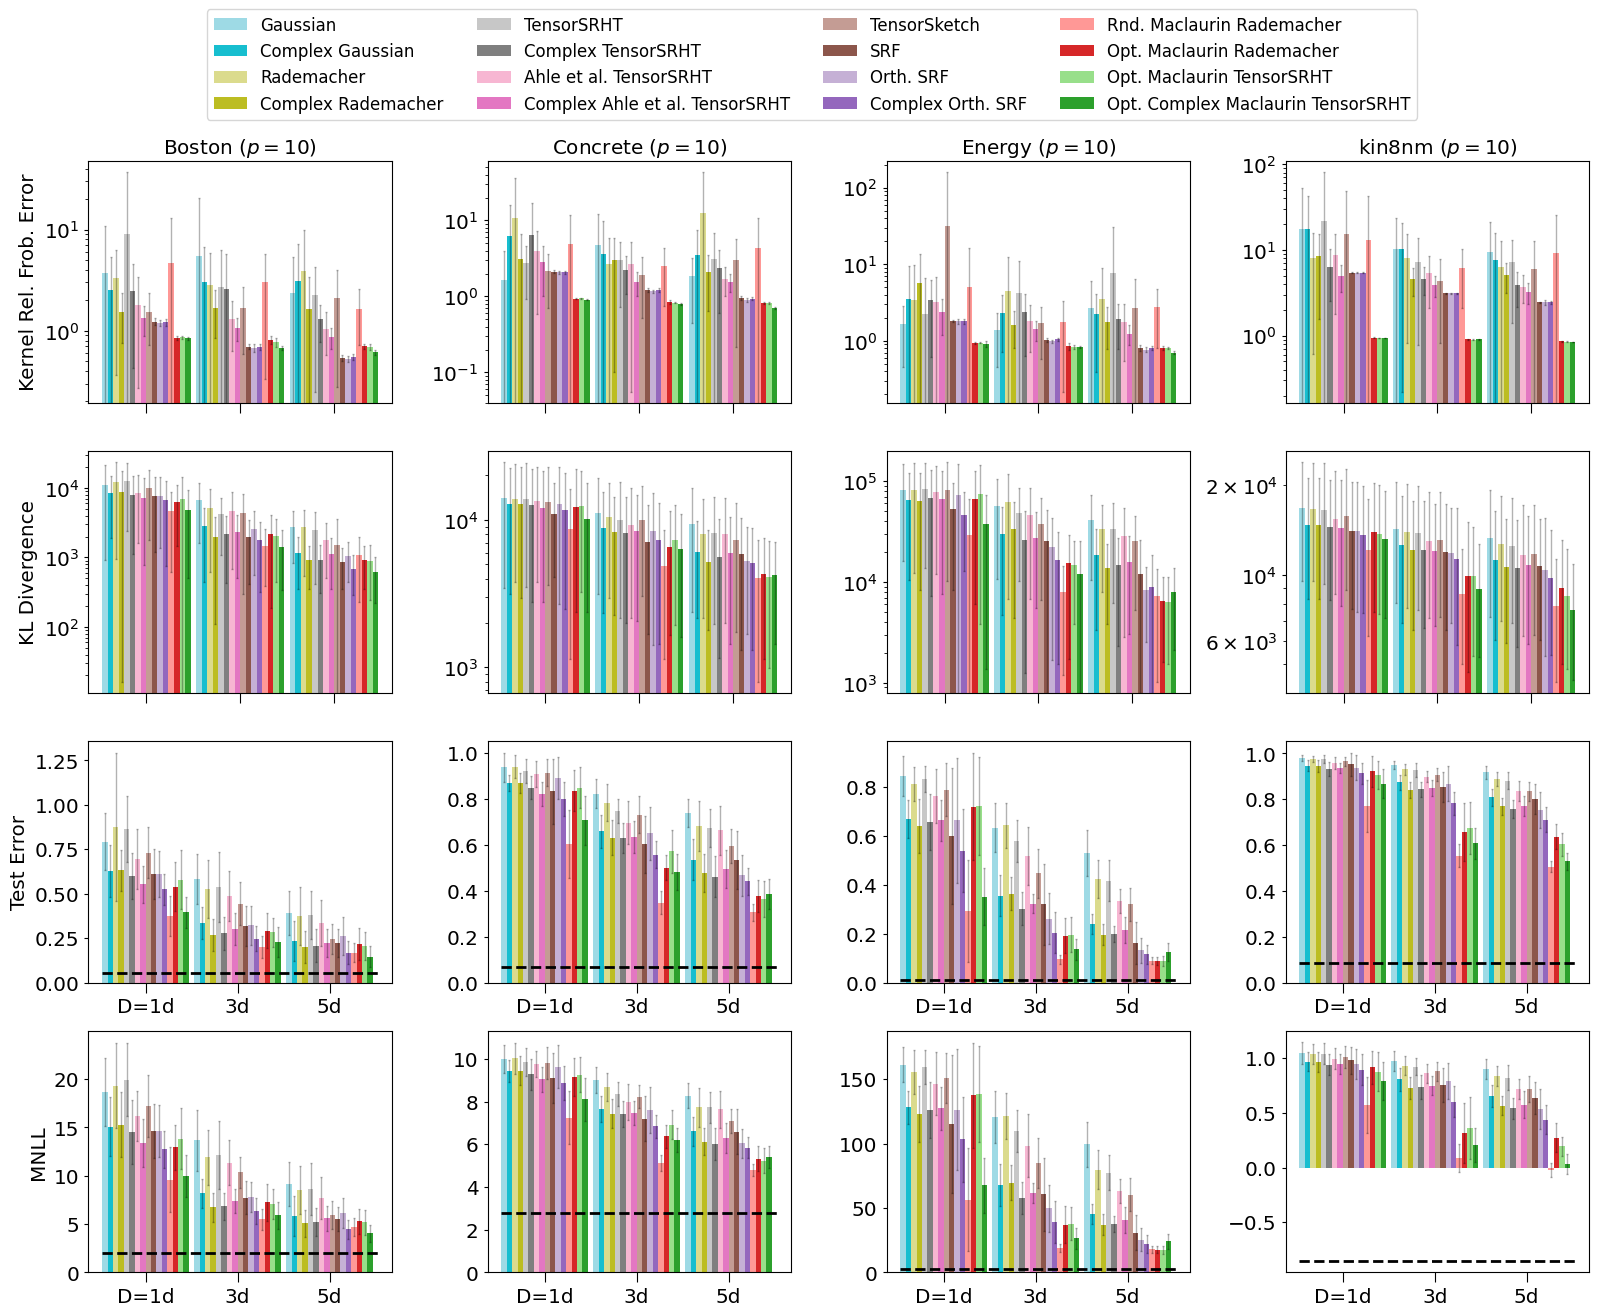

In [105]:
csv_files = [
    '../csv/poly10_approx_a2/Boston_d16_n506_centering_True.csv',
    '../csv/poly10_approx_a2/Concrete_d8_n1030_centering_True.csv',
    '../csv/poly10_approx_a2/Energy_d8_n768_centering_True.csv',
    '../csv/poly10_approx_a2/kin8nm_d8_n8192_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=False, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=False, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.25,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/mnist_cifar10_big.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

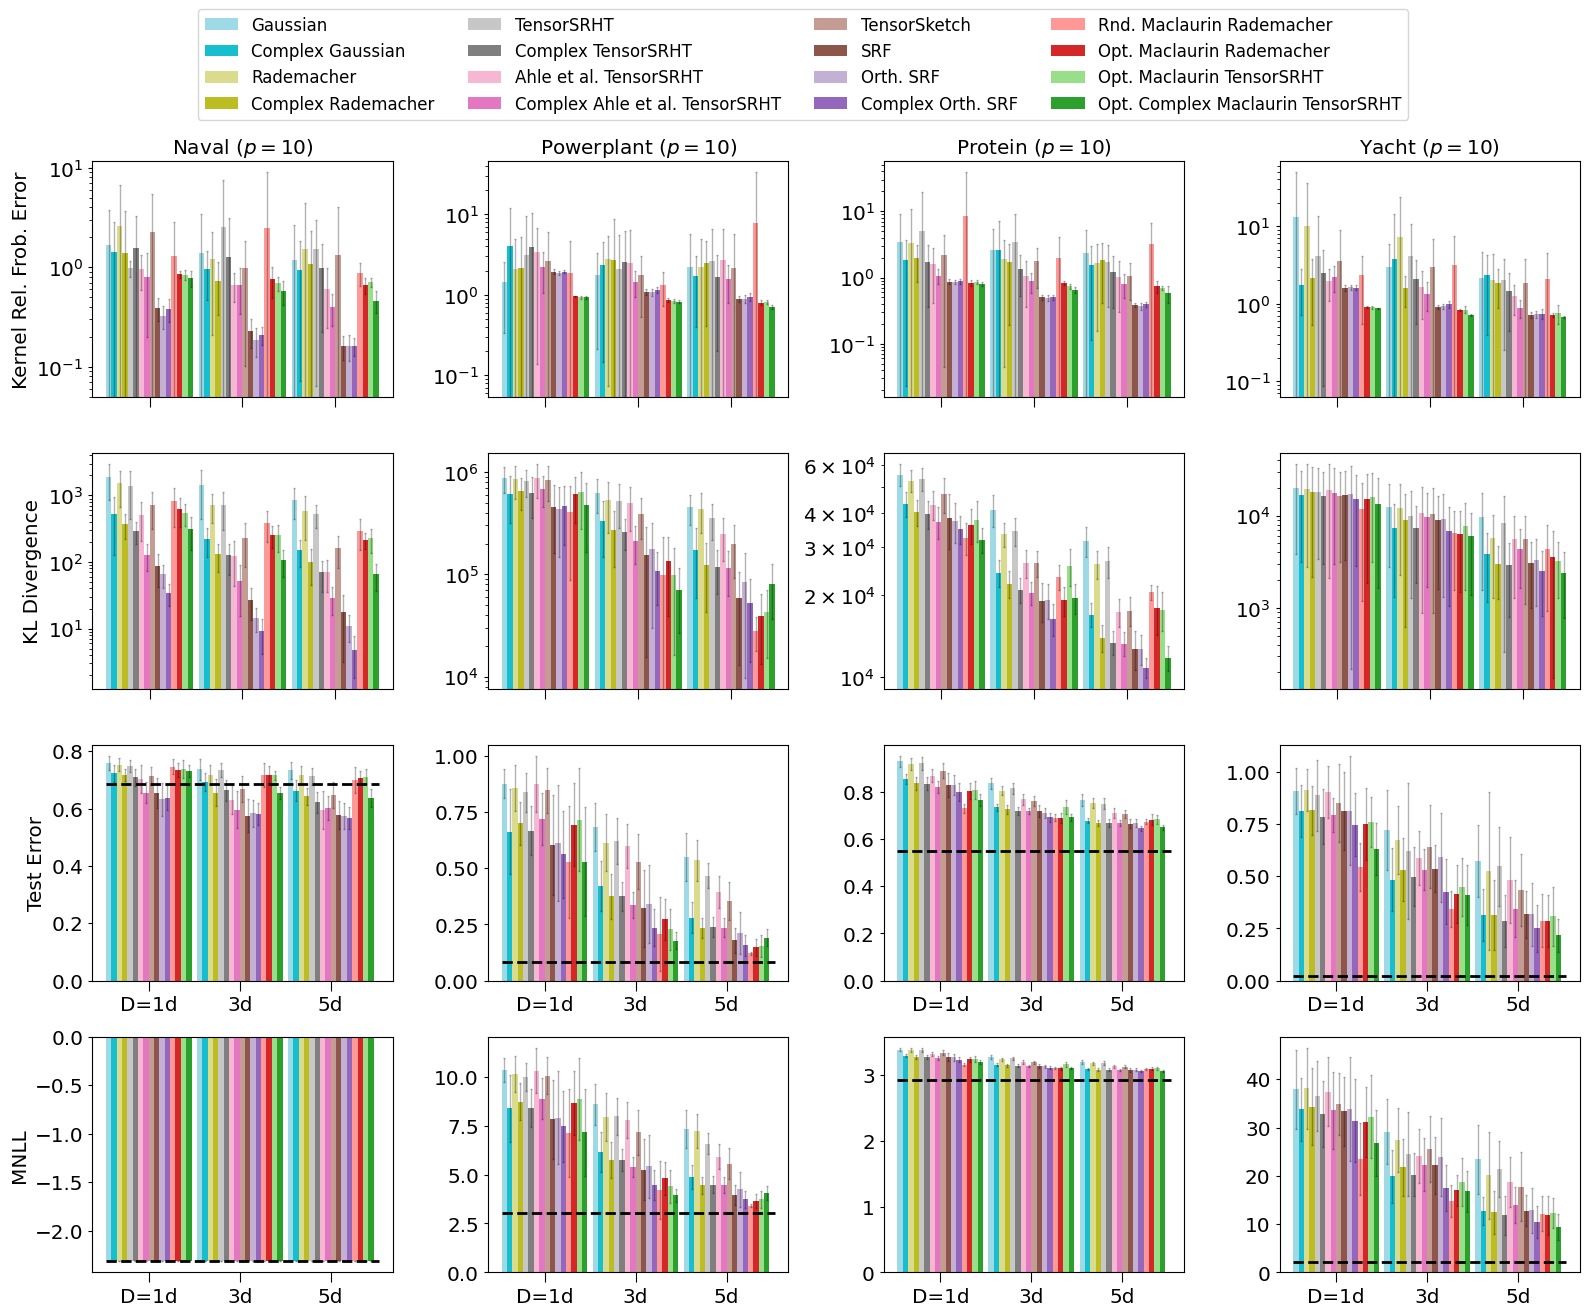

In [114]:
csv_files = [
    '../csv/poly10_approx_a2/Naval_d16_n11934_centering_True.csv',
    '../csv/poly10_approx_a2/Powerplant_d4_n9568_centering_True.csv',
    '../csv/poly10_approx_a2/Protein_d16_n45730_centering_True.csv',
    '../csv/poly10_approx_a2/Yacht_d8_n308_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=False, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=False, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.25,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/mnist_cifar10_big.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

## Final plots

### p=3,7,10 Frobenius only

In [9]:
# colors = plt.get_cmap('hsv')(np.linspace(0, 1, 10))
reds = plt.get_cmap('YlOrRd')(np.linspace(0.4, 1, 3))
blues = plt.get_cmap('GnBu')(np.linspace(0.4, 1, 4))

In [11]:
configs = [
    ('Gaussian', {'method': 'poly_sketch', 'proj': 'gaussian', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[2]}),
    ('Gaussian Comp.', {'method': 'poly_sketch', 'proj': 'gaussian', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[3]}),
    ('Rademacher', {'method': 'poly_sketch', 'proj': 'rademacher', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[4]}),
    ('Rademacher Comp.', {'method': 'poly_sketch', 'proj': 'rademacher', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[5]}),
    ('TensorSRHT', {'method': 'poly_sketch', 'proj': 'srht', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[10]}),
    ('TensorSRHT Comp.', {'method': 'poly_sketch', 'proj': 'srht', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[11]}),
    ('TensorSketch', {'method': 'poly_sketch', 'proj': 'countsketch_scatter', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[8]}),
    # ('SRF', {'method': 'srf', 'proj': 'gaussian', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[9]}),
    # ('Orth. SRF', {'method': 'srf', 'proj': 'srht', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[10]}),
    # ('Complex Orth. SRF', {'method': 'srf', 'proj': 'srht', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[11]}),
    ('Rnd. Macl. Radem.', {'method': 'maclaurin_p', 'proj': 'rademacher', 'complex': False, 'ahle': False, 'comp_real': False, 'color': blues[0]}),
    ('Opt. Macl. Radem.', {'method': 'maclaurin', 'proj': 'rademacher', 'complex': False, 'ahle': False, 'comp_real': False, 'color': blues[1]}),
    ('Opt. Macl. TensorSRHT', {'method': 'maclaurin', 'proj': 'srht', 'complex': False, 'ahle': False, 'comp_real': False, 'color': blues[2]}),
    ('Opt. Macl. TensorSRHT Comp.', {'method': 'maclaurin', 'proj': 'srht', 'complex': True, 'ahle': False, 'comp_real': False, 'color': blues[3]}),
    # ('Ahle et al. TensorSRHT', {'method': 'poly_sketch', 'proj': 'srht', 'complex': False, 'ahle': True, 'comp_real': False, 'color': colors[6]}),
    # ('Complex Ahle et al. TensorSRHT', {'method': 'poly_sketch', 'proj': 'srht', 'complex': True, 'ahle': True, 'comp_real': False, 'color': colors[7]}),
]

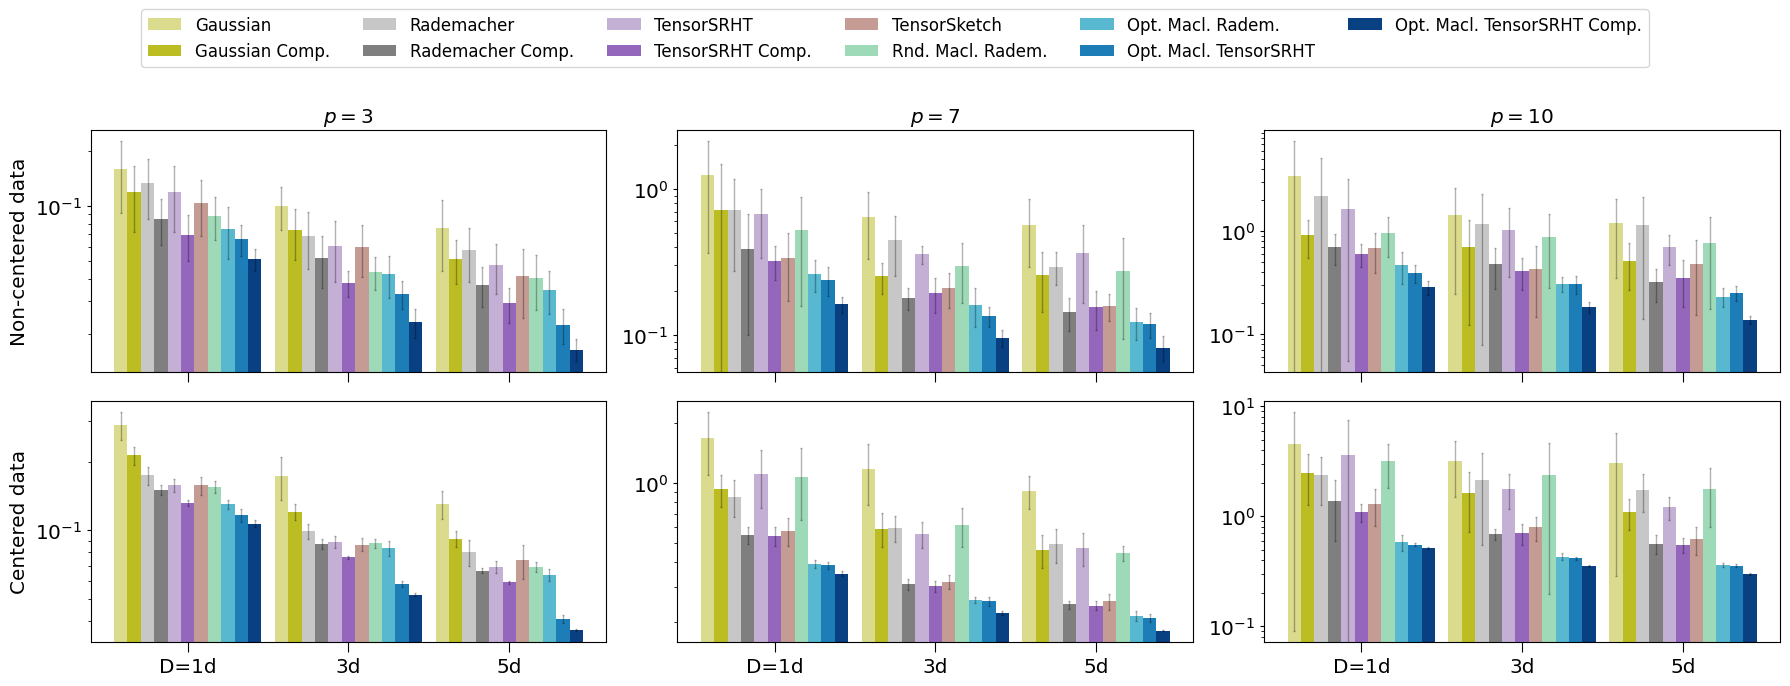

In [12]:
csv_files_noncentered = [
    '../csv/poly3_approx_a2/FashionMNIST_d1024_n70000_centering_False.csv',
    '../csv/poly7_approx_a2/FashionMNIST_d1024_n70000_centering_False.csv',
    '../csv/poly10_approx_a2/FashionMNIST_d1024_n70000_centering_False.csv'
]

csv_files_centered = [
    '../csv/poly3_approx_a2/FashionMNIST_d1024_n70000_centering_True.csv',
    '../csv/poly7_approx_a2/FashionMNIST_d1024_n70000_centering_True.csv',
    '../csv/poly10_approx_a2/FashionMNIST_d1024_n70000_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18, 6))

for i, csv in enumerate(csv_files_noncentered):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Non-centered data' if i==0 else ''
    plot_csv(axes[0, i], csv_files_noncentered[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'$p={p}$', x_axis=False, ylabel=ylabel)

    ylabel='Centered data' if i==0 else ''
    plot_csv(axes[1, i], csv_files_centered[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title='', x_axis=True, ylabel=ylabel)

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=6, bbox_to_anchor = (0,0.3,1.00,0.85), bbox_transform=plt.gcf().transFigure)
plt.savefig('../figures/frob_comparison_fmnist_revision.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

**Summary**
- Here we compare only unbiased approximations (polynomial sketches) in terms of kernel approximation error (rel Frob error)
- Optimized Macl. TensorSRHT works best on centered data and p=3. Ahle outperforms for large p when data is non-centered.
- In general, optimized Maclaurin is recommended for zero-centered data.
- But Table 3 shows that performance is better overall for centered data (on all datasets) for p=20 (a=4)

In [13]:
configs = [
    # ('Gaussian', {'method': 'poly_sketch', 'proj': 'gaussian', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[0]}),
    # ('Complex Gaussian', {'method': 'poly_sketch', 'proj': 'gaussian', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[1]}),
    # ('Rademacher', {'method': 'poly_sketch', 'proj': 'rademacher', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[2]}),
    # ('Complex Rademacher', {'method': 'poly_sketch', 'proj': 'rademacher', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[3]}),
    # ('TensorSketch', {'method': 'poly_sketch', 'proj': 'countsketch_scatter', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[8]}),
    ('SRF', {'method': 'srf', 'proj': 'gaussian', 'complex': False, 'ahle': False, 'comp_real': False, 'color': reds[0]}),
    ('SRF Orth.', {'method': 'srf', 'proj': 'srht', 'complex': False, 'ahle': False, 'comp_real': False, 'color': reds[1]}),
    ('SRF Orth. Comp.', {'method': 'srf', 'proj': 'srht', 'complex': True, 'ahle': False, 'comp_real': False, 'color': reds[2]}),
    ('TensorSRHT', {'method': 'poly_sketch', 'proj': 'srht', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[10]}),
    ('TensorSRHT Comp.', {'method': 'poly_sketch', 'proj': 'srht', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[11]}),
    ('Ahle et al. TensorSRHT', {'method': 'poly_sketch', 'proj': 'srht', 'complex': False, 'ahle': True, 'comp_real': False, 'color': colors[6]}),
    ('Ahle et al. TensorSRHT Comp.', {'method': 'poly_sketch', 'proj': 'srht', 'complex': True, 'ahle': True, 'comp_real': False, 'color': colors[7]}),
    # ('Rnd. Maclaurin Rademacher', {'method': 'maclaurin_p', 'proj': 'rademacher', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[12]}),
    ('Opt. Macl. Radem.', {'method': 'maclaurin', 'proj': 'rademacher', 'complex': False, 'ahle': False, 'comp_real': False, 'color': blues[1]}),
    ('Opt. Macl. TensorSRHT', {'method': 'maclaurin', 'proj': 'srht', 'complex': False, 'ahle': False, 'comp_real': False, 'color': blues[2]}),
    ('Opt. Macl. TensorSRHT Comp.', {'method': 'maclaurin', 'proj': 'srht', 'complex': True, 'ahle': False, 'comp_real': False, 'color': blues[3]}),
]

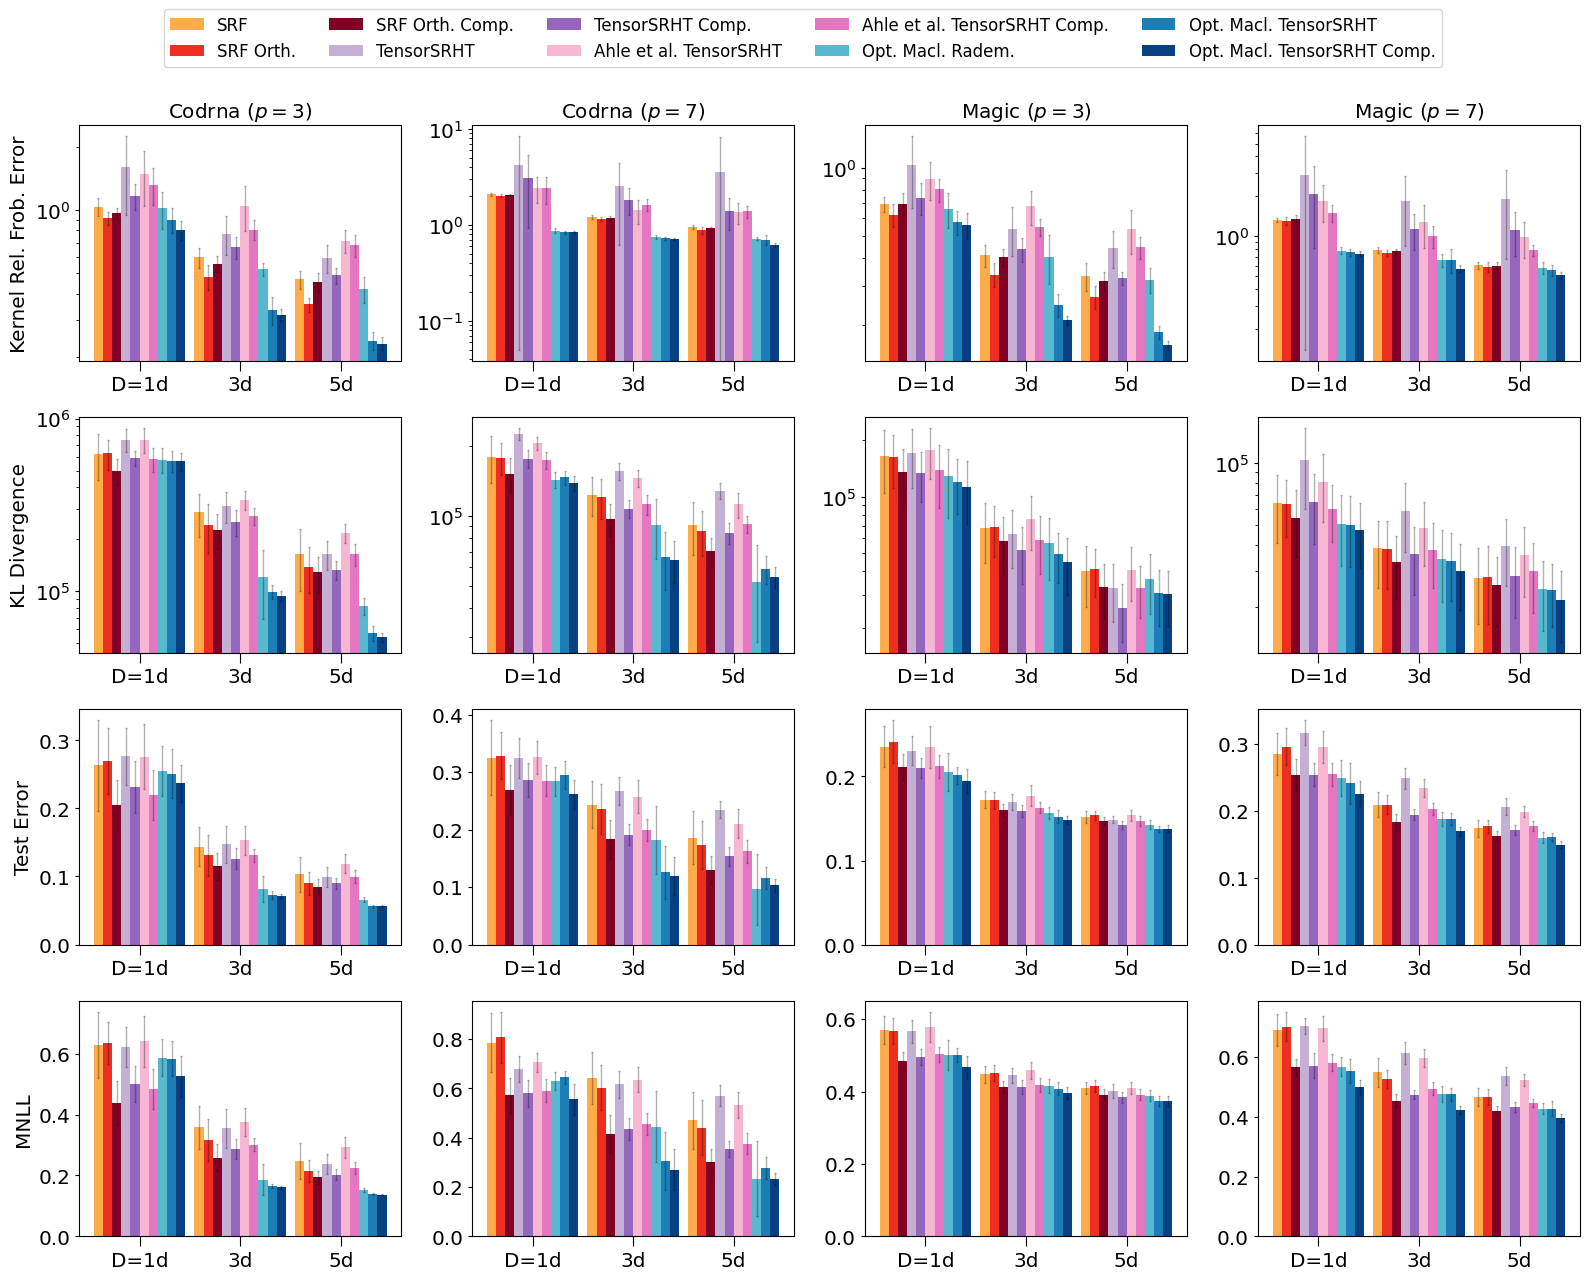

In [14]:
csv_files = [
    '../csv/poly3_approx_a2/Codrna_d8_n331152_centering_True.csv',
    '../csv/poly7_approx_a2/Codrna_d8_n331152_centering_True.csv',
    '../csv/poly3_approx_a2/Magic_d16_n19020_centering_True.csv',
    '../csv/poly7_approx_a2/Magic_d16_n19020_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=False, plot_full_kernel=False) # 

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=False, plot_full_kernel=False) # 

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=5, bbox_to_anchor = (0,0.22,1.01,0.85), bbox_transform=plt.gcf().transFigure)
plt.savefig('../figures/poly_classification_cordrna_magic.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

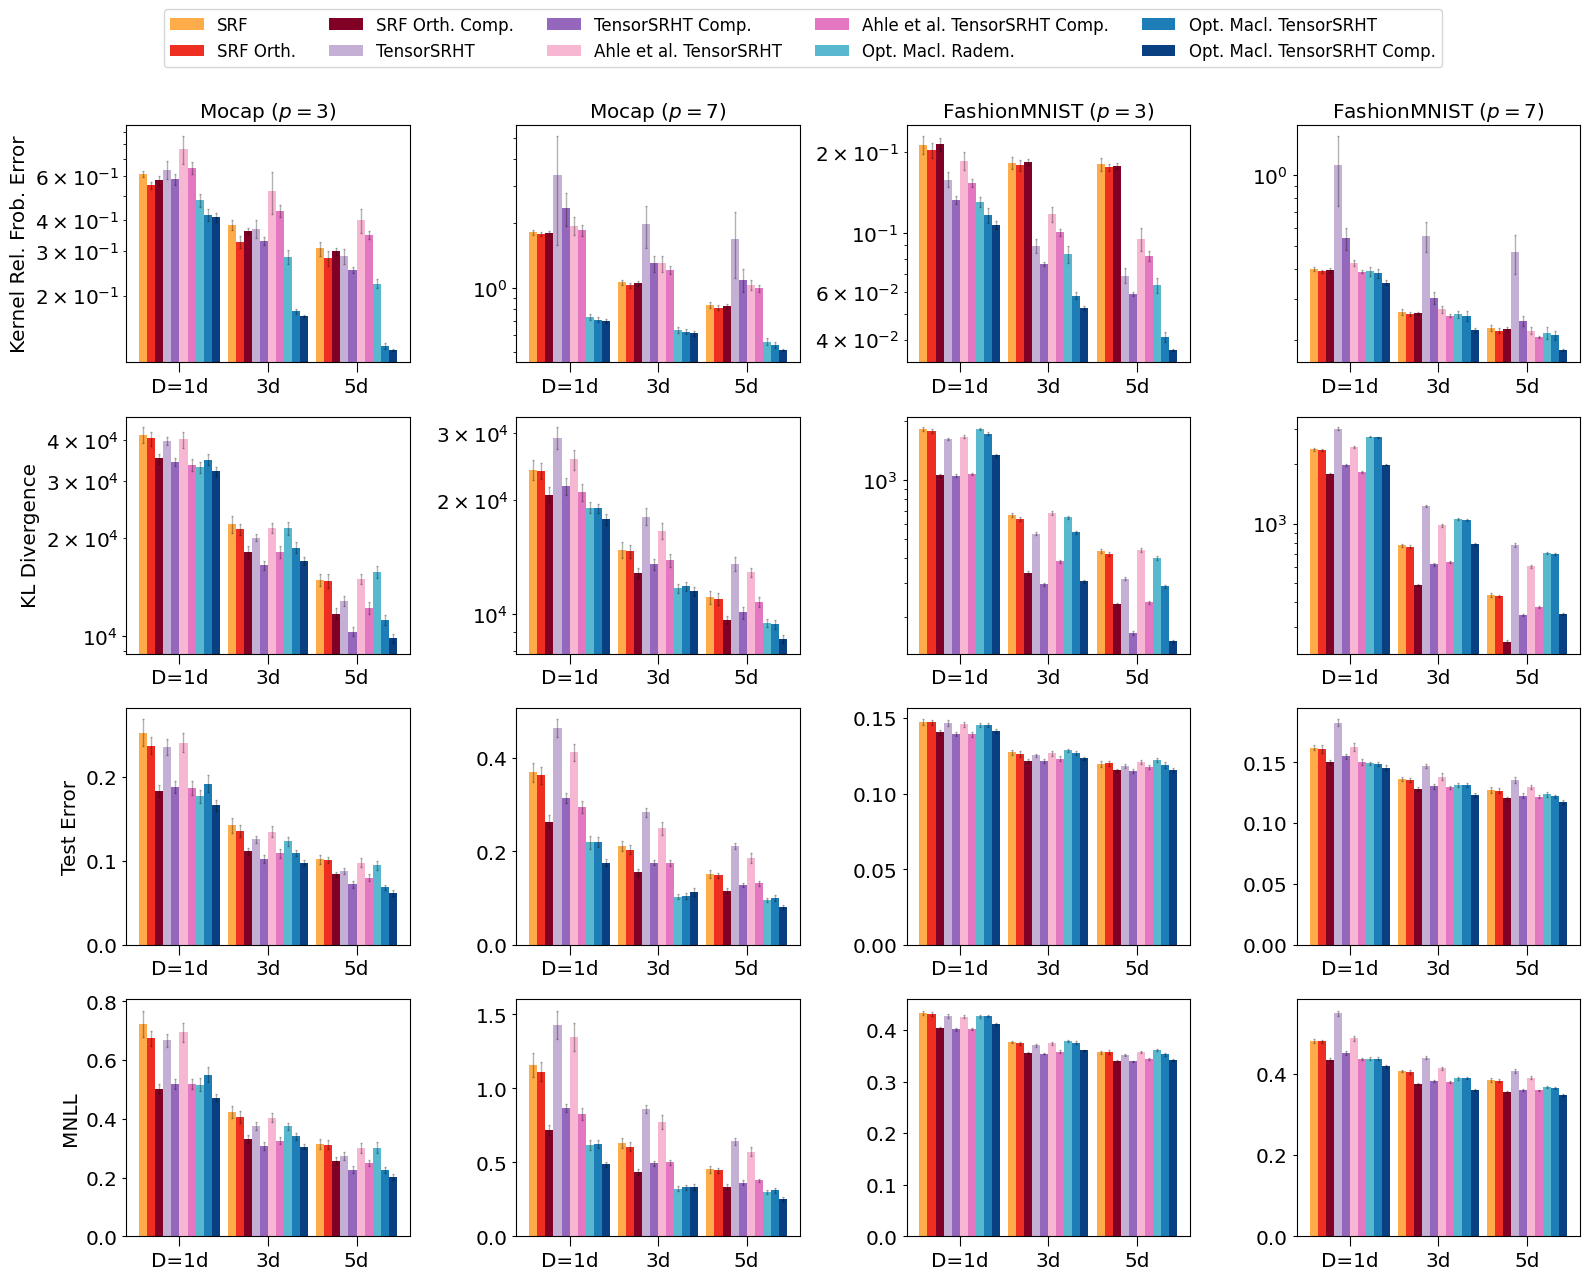

In [15]:
csv_files = [
    '../csv/poly3_approx_a2/Mocap_d64_n78095_centering_True.csv',
    '../csv/poly7_approx_a2/Mocap_d64_n78095_centering_True.csv',
    '../csv/poly3_approx_a2/FashionMNIST_d1024_n70000_centering_True.csv',
    '../csv/poly7_approx_a2/FashionMNIST_d1024_n70000_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=False, plot_full_kernel=False) # 

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=False, plot_full_kernel=False) # 

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=5, bbox_to_anchor = (0,0.22,1.01,0.85), bbox_transform=plt.gcf().transFigure)
plt.savefig('../figures/poly_classification_mocap_fashionmnist.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

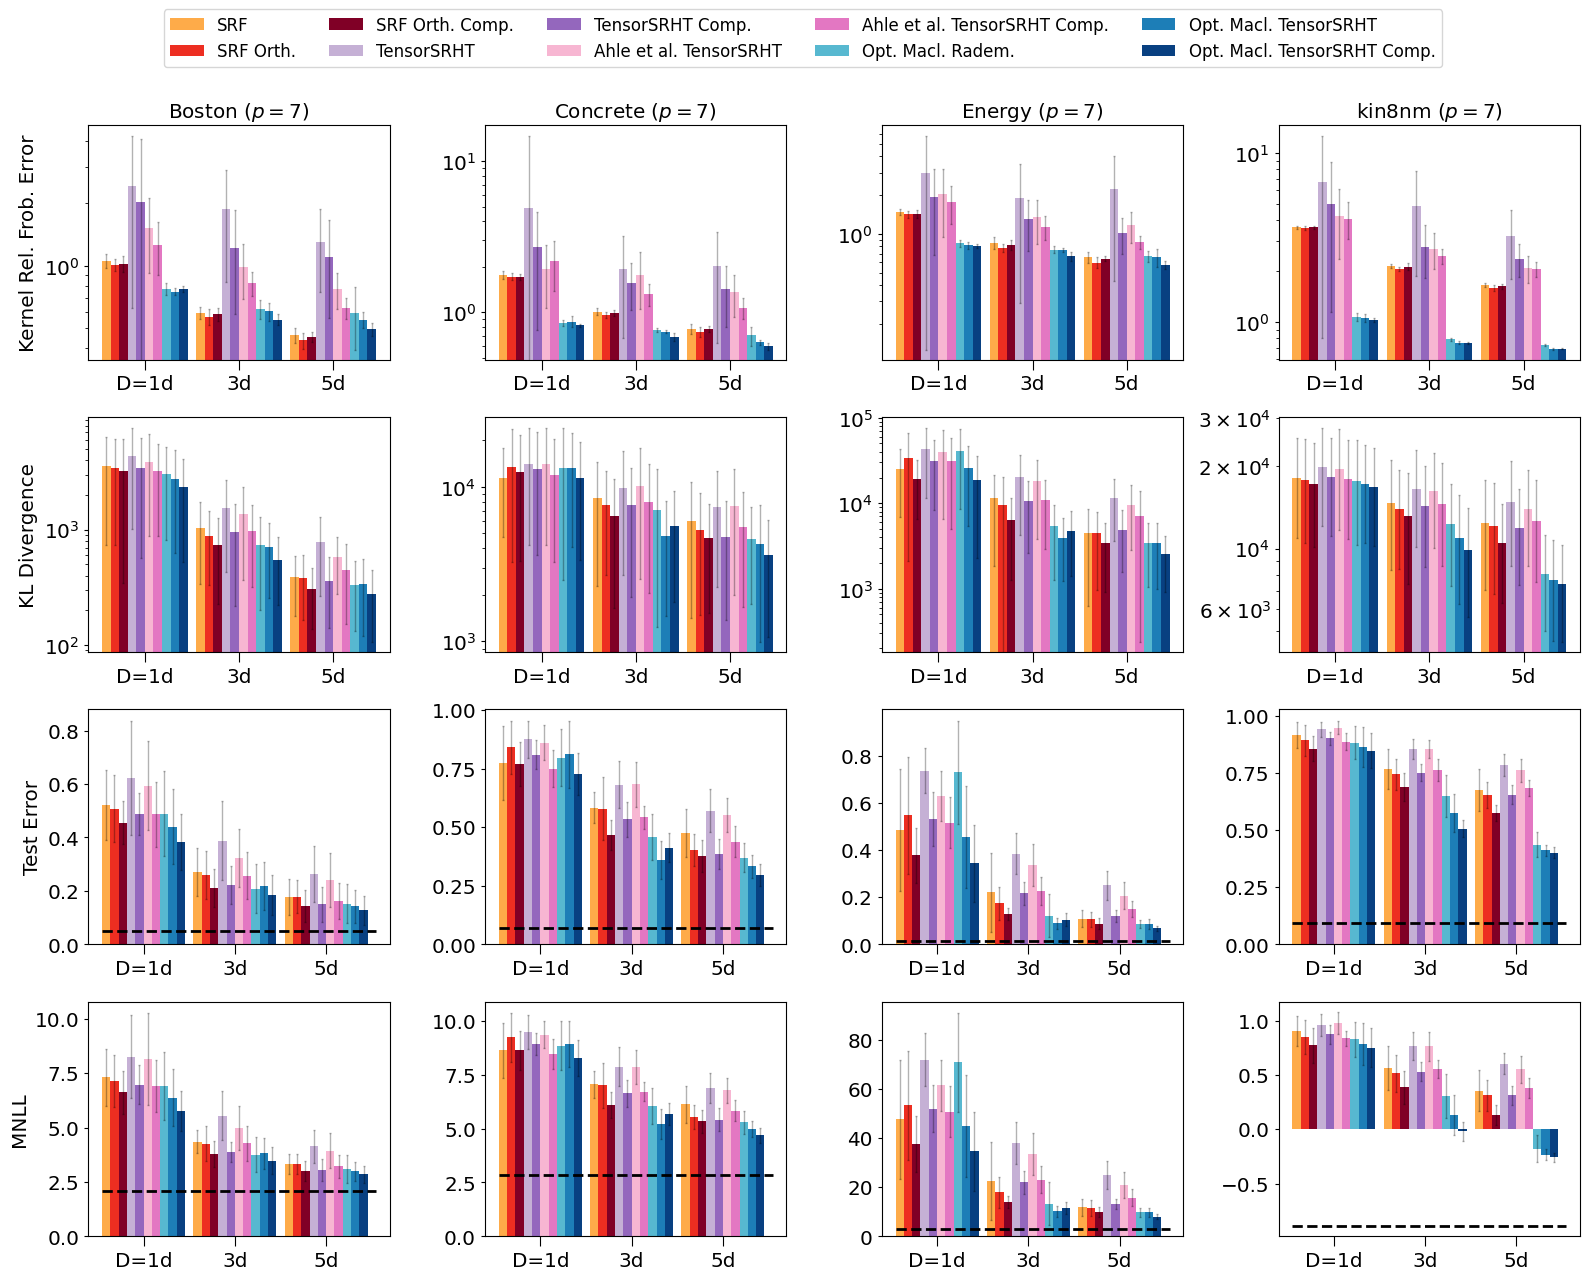

In [16]:
csv_files = [
    '../csv/poly7_approx_a2/Boston_d16_n506_centering_True.csv',
    '../csv/poly7_approx_a2/Concrete_d8_n1030_centering_True.csv',
    '../csv/poly7_approx_a2/Energy_d8_n768_centering_True.csv',
    '../csv/poly7_approx_a2/kin8nm_d8_n8192_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=True, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=True, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=5, bbox_to_anchor = (0,0.22,1.01,0.85), bbox_transform=plt.gcf().transFigure)
plt.savefig('../figures/poly7_regression_boston_to_kin8nm.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

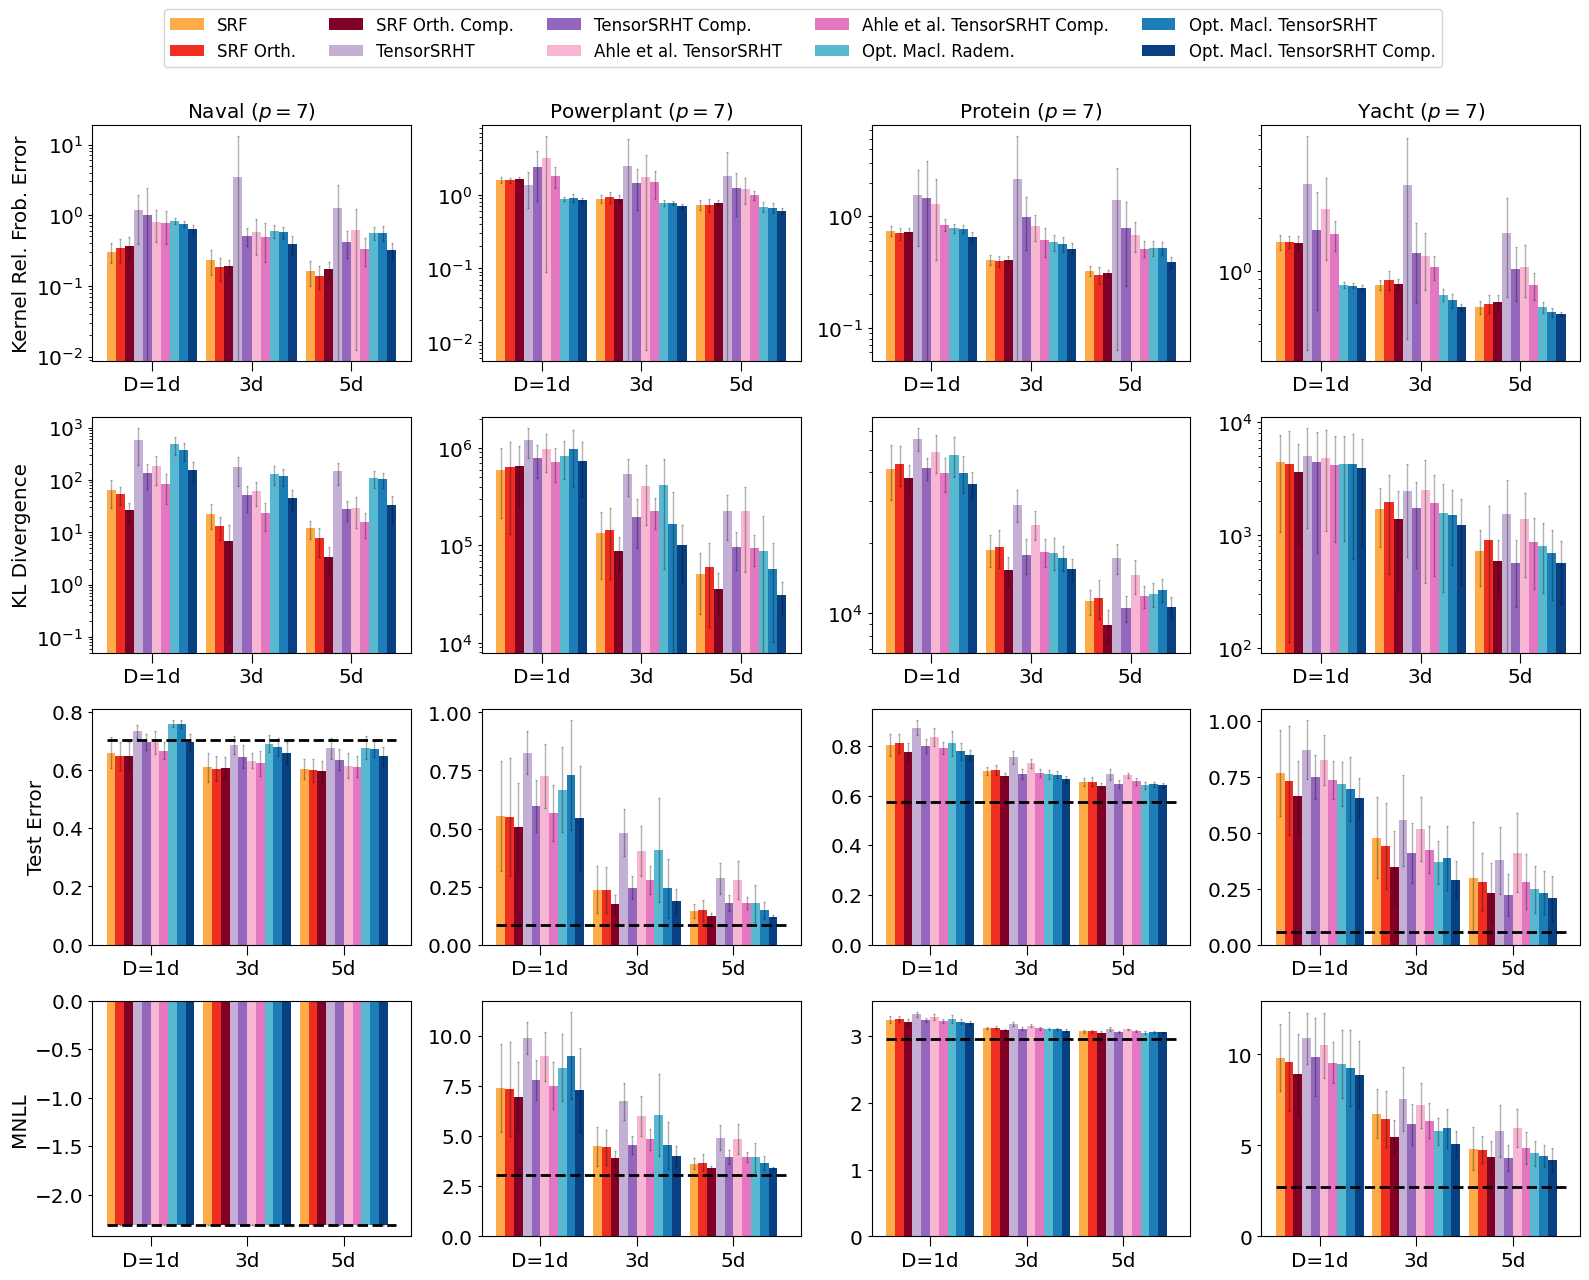

In [17]:
csv_files = [
    '../csv/poly7_approx_a2/Naval_d16_n11934_centering_True.csv',
    '../csv/poly7_approx_a2/Powerplant_d4_n9568_centering_True.csv',
    '../csv/poly7_approx_a2/Protein_d16_n45730_centering_True.csv',
    '../csv/poly7_approx_a2/Yacht_d8_n308_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=True, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=True, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=5, bbox_to_anchor = (0,0.22,1.01,0.85), bbox_transform=plt.gcf().transFigure)
plt.savefig('../figures/poly7_regression_naval_to_yacht.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

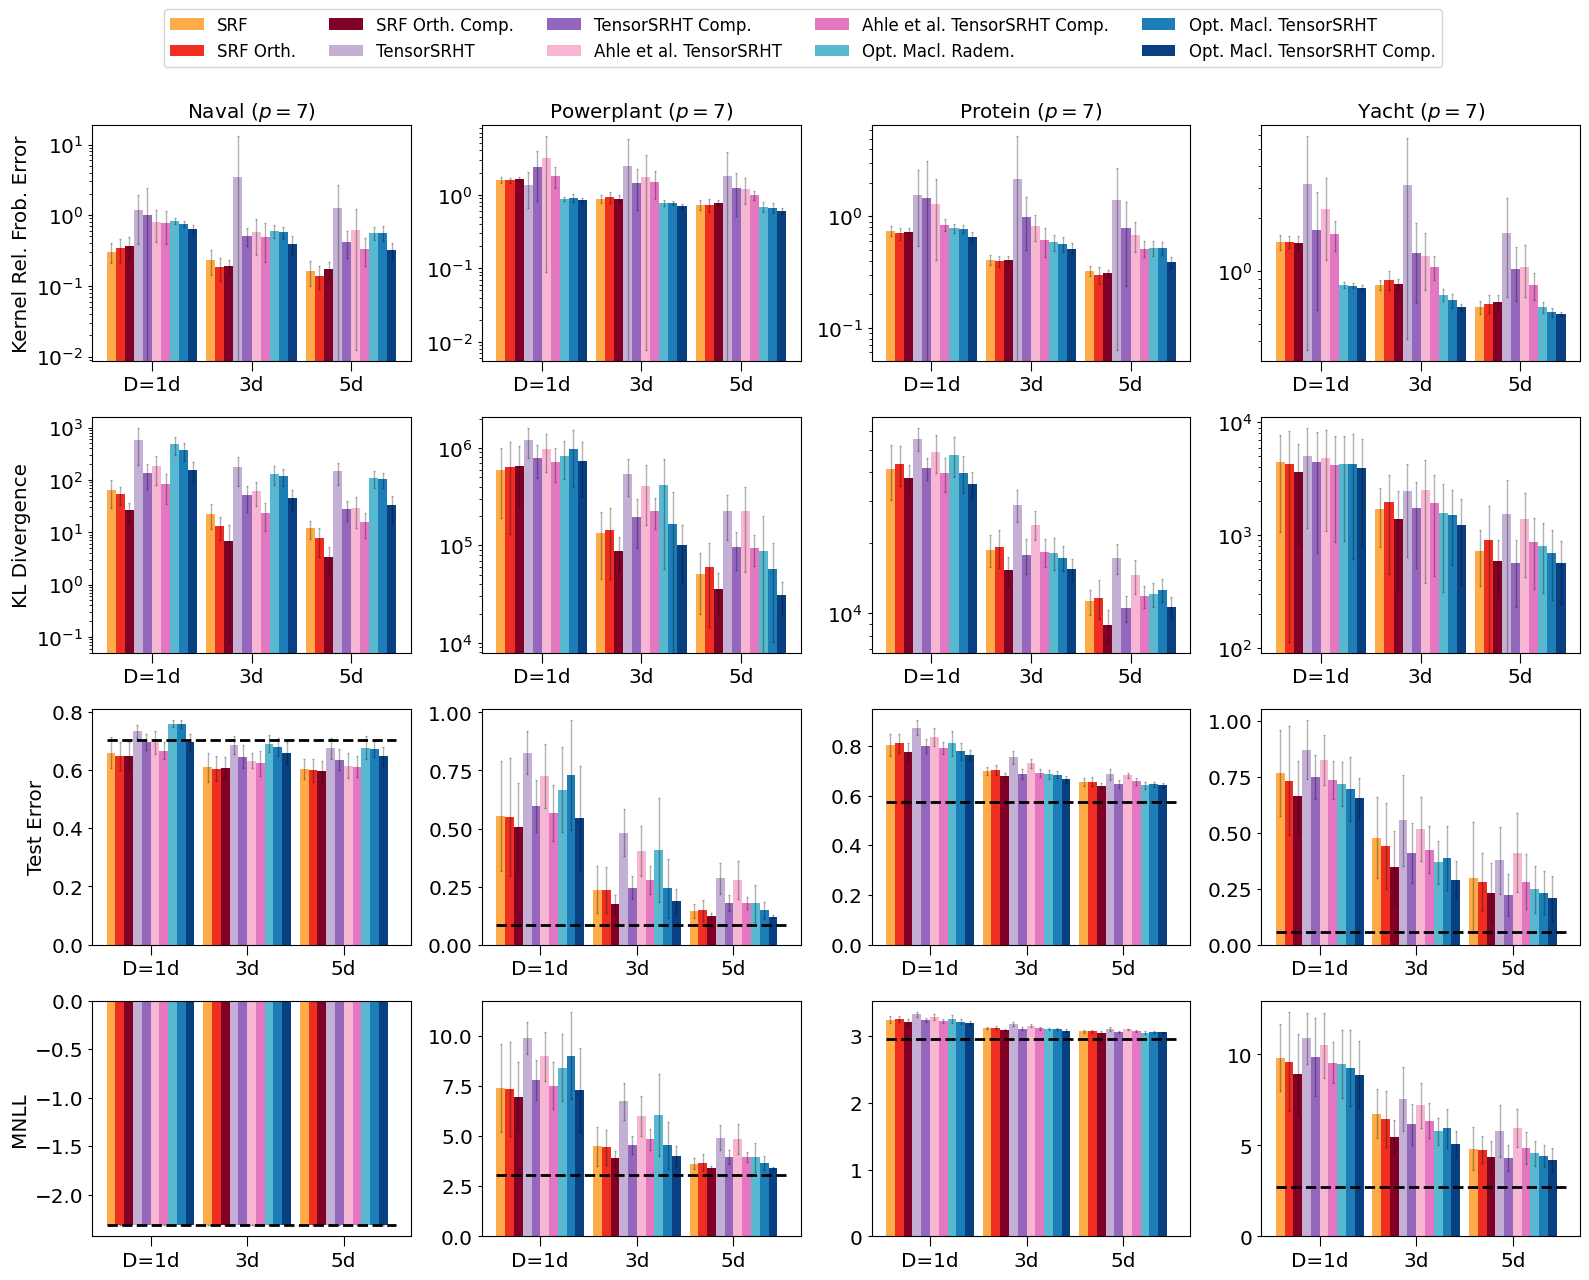

In [18]:
csv_files = [
    '../csv/poly7_approx_a2/Naval_d16_n11934_centering_True.csv',
    '../csv/poly7_approx_a2/Powerplant_d4_n9568_centering_True.csv',
    '../csv/poly7_approx_a2/Protein_d16_n45730_centering_True.csv',
    '../csv/poly7_approx_a2/Yacht_d8_n308_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=True, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=True, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=True, plot_full_kernel=True) # 

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=5, bbox_to_anchor = (0,0.22,1.01,0.85), bbox_transform=plt.gcf().transFigure)
plt.savefig('../figures/poly7_regression_naval_to_yacht.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

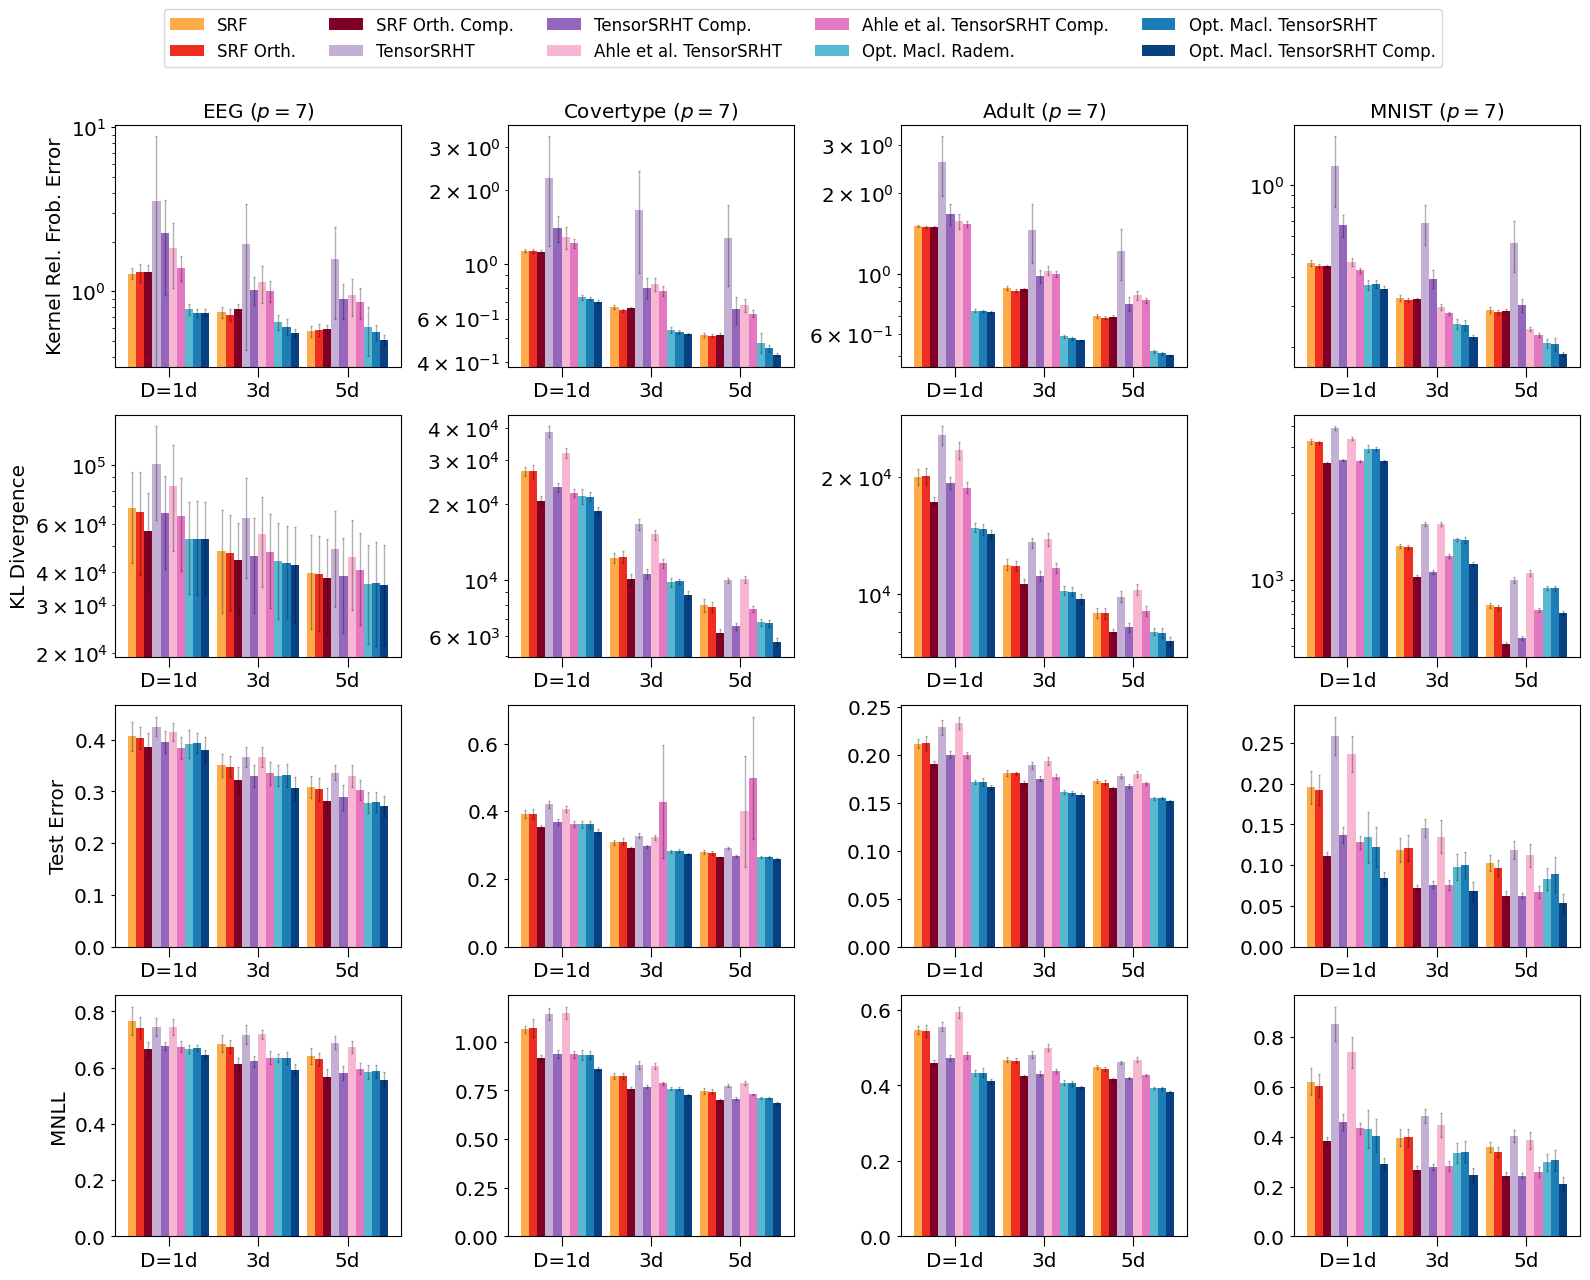

In [19]:
csv_files = [
    '../csv/poly7_approx_a2/EEG_d16_n14980_centering_True.csv',
    '../csv/poly7_approx_a2/Covertype_d64_n581012_centering_True.csv',
    '../csv/poly7_approx_a2/Adult_d128_n48842_centering_True.csv',
    '../csv/poly7_approx_a2/MNIST_d1024_n70000_centering_True.csv'
]

Ds = [1, 3, 5] # 15
D_labels = [r'D=1d', r'3d', r'5d']

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(16, 12))

for i, csv in enumerate(csv_files):
    p = int(re.findall(r'\d+', csv.split('/')[-2])[0])
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Kernel Rel. Frob. Error' if i==0 else ''
    plot_csv(axes[0,i], csv_files[i], configs, Ds, D_labels, error_field='k_rel_frob_error', logscale=True, title=f'{name} ($p={p}$)', x_axis=True, ylabel=ylabel)

    ylabel='KL Divergence' if i==0 else ''
    plot_csv(axes[1,i], csv_files[i], configs, Ds, D_labels, error_field='test_kl', logscale=True, title='', x_axis=True, ylabel=ylabel)

    ylabel='Test Error' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[2,i], csv_files[i], configs, Ds, D_labels, error_field='test_error', y_lim=None, title='', ylabel=ylabel, regression=False, plot_full_kernel=False) # 

    ylabel='MNLL' if i==0 else ''
    # (0.01, 0.17)
    plot_csv(axes[3,i], csv_files[i], configs, Ds, D_labels, error_field='test_mnll', y_lim=None, title='', ylabel=ylabel, regression=False, plot_full_kernel=False) # 

handles, labels = axes[0,0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=5, bbox_to_anchor = (0,0.22,1.01,0.85), bbox_transform=plt.gcf().transFigure)
plt.savefig('../figures/poly7_classification_eeg_to_mnist.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

## Generate Table

In [ ]:
# p=7: Zero-center vs. non zero-center
# Frob Error, Test Error or MNLL
# Output as DataFrame

In [9]:
csv_files = [
    "../csv/poly7_approx_a2/Boston_d16_n506",
    "../csv/poly7_approx_a2/Concrete_d8_n1030",
    "../csv/poly7_approx_a2/Energy_d8_n768",
    "../csv/poly7_approx_a2/kin8nm_d8_n8192",
    "../csv/poly7_approx_a2/Naval_d16_n11934",
    "../csv/poly7_approx_a2/Powerplant_d4_n9568",
    "../csv/poly7_approx_a2/Protein_d16_n45730",
    "../csv/poly7_approx_a2/Yacht_d8_n308",
    "../csv/poly7_approx_a2/Adult_d128_n48842",
    "../csv/poly7_approx_a2/Codrna_d8_n331152",
    '../csv/poly7_approx_a2/Covertype_d64_n581012',
    "../csv/poly7_approx_a2/EEG_d16_n14980",
    "../csv/poly7_approx_a2/FashionMNIST_d1024_n70000",
    "../csv/poly7_approx_a2/Magic_d16_n19020",
    '../csv/poly7_approx_a2/MNIST_d1024_n70000',
    "../csv/poly7_approx_a2/Mocap_d64_n78095"
]

In [10]:
for file in csv_files:
    line = []
    for metric in ['test_mnll', 'k_rel_frob_error']:
        # determine best scoring
        for suffix in ['_centering_False.csv', '_centering_True.csv']:
            df = pd.read_csv(file + suffix)
            D_max = df['D'].unique().max()
        
            macl_rad = (df['method'] == 'maclaurin') & (df['proj'] == 'rademacher') & (df['comp'] == False) & (df['D']==D_max)
            srf = (df['method'] == 'srf') & (df['proj'] == 'gaussian') & (df['comp'] == False) & (df['D']==D_max)
            macl_rad_metric = df.loc[macl_rad, metric]
            srf_metric = df.loc[srf, metric]

            metric_string = f"{srf_metric.mean():.2f} ({srf_metric.std():.2f}) & {macl_rad_metric.mean():.2f} ({macl_rad_metric.std():.2f})"
            line.append(metric_string)

    print(" & ".join(line))

3.37 (0.14) & 3.43 (0.14) & 3.31 (0.45) & 3.10 (0.63) & 0.06 (0.04) & 0.23 (0.10) & 0.46 (0.04) & 0.59 (0.20)
3.71 (0.16) & 3.77 (0.16) & 6.12 (0.87) & 5.29 (0.53) & 0.22 (0.03) & 0.53 (0.16) & 0.78 (0.06) & 0.70 (0.10)
5.48 (0.11) & 5.52 (0.11) & 11.86 (3.36) & 9.88 (1.79) & 0.11 (0.07) & 0.38 (0.13) & 0.66 (0.06) & 0.67 (0.06)
0.09 (0.06) & 0.05 (0.08) & 0.36 (0.19) & -0.18 (0.13) & 0.25 (0.04) & 0.51 (0.12) & 1.65 (0.05) & 0.73 (0.01)
-2.31 (0.00) & -2.31 (0.00) & -2.31 (0.00) & -2.31 (0.00) & 0.01 (0.00) & 0.03 (0.01) & 0.16 (0.06) & 0.56 (0.12)
3.11 (0.03) & 3.12 (0.03) & 3.63 (0.26) & 3.93 (0.73) & 0.11 (0.05) & 0.56 (0.18) & 0.73 (0.11) & 0.69 (0.10)
nan (nan) & 3.23 (0.01) & 3.07 (0.02) & 3.05 (0.02) & nan (nan) & 0.01 (0.00) & 0.32 (0.03) & 0.52 (0.08)
3.97 (0.20) & 4.07 (0.20) & 4.83 (1.17) & 4.56 (0.69) & 0.12 (0.05) & 0.28 (0.13) & 0.62 (0.05) & 0.62 (0.04)
0.58 (0.00) & 0.58 (0.00) & 0.45 (0.01) & 0.39 (0.00) & 0.00 (0.00) & 0.00 (0.00) & 0.70 (0.01) & 0.52 (0.01)
0.65 (0.